In [23]:
import time
t_start = time.time()

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # suppress tensorflow information messages

import sys
import numpy as np
from scipy import stats
import scipy as sp
import multiprocessing
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

HOME_PATH = os.path.abspath("/root/work/QE-mls") # path to QE_mls
sys.path.append(HOME_PATH + "/qe")
print("Home path:", HOME_PATH)

# custom modules
import paper_plot as pp
# Import the W boson regressor module
import nn_pcres as nn
nn.BATCH_SIZE = 2048


Home path: /root/work/QE-mls


In [24]:
# ROOT need to be imported after tensorflow
import ROOT
from ROOT import TLorentzVector, TVector3

# some global variables
dir_name = HOME_PATH + "/14th_trial/reg_main/ww_resregressor_result/"
plot = pp.Plotter()
WORKERS = 20

In [25]:
import h5py


def load_particles_from_h5(filename):
    """
    Load particle data from an HDF5 file

    Args:
        filename: Path to the HDF5 file

    Returns:
        Dictionary with the loaded data
    """
    result = {}

    with h5py.File(filename, "r") as f:
        # For each group in the file
        for group_name in f.keys():
            group_data = {}

            # Load datasets (numpy arrays)
            for dataset_name in f[group_name].keys():
                group_data[dataset_name] = f[group_name][dataset_name][:]

            # Load attributes (scalars)
            for attr_name, attr_value in f[group_name].attrs.items():
                group_data[attr_name] = attr_value

            result[group_name] = group_data

    return result

In [26]:
mc20_data = load_particles_from_h5("/root/data/mc20_truth_LL.h5")
mc20_data.keys()
mc20_data_sm = load_particles_from_h5("/root/data/mc20_truth.h5")

In [48]:
# SM truth
truth_lead_lep = mc20_data_sm["truth_lead_lep"]
truth_sublead_lep = mc20_data_sm["truth_sublead_lep"]
truth_lead_nu = mc20_data_sm["truth_lead_nu"]
truth_sublead_nu = mc20_data_sm["truth_sublead_nu"]
truth_lead_lep_p4 = mc20_data_sm["truth_lead_lep"]["p4"]
truth_sublead_lep_p4 = mc20_data_sm["truth_sublead_lep"]["p4"]
truth_lead_nu_p4 = mc20_data_sm["truth_lead_nu"]["p4"]
truth_sublead_nu_p4 = mc20_data_sm["truth_sublead_nu"]["p4"]
truth_met_pt = np.sqrt(np.square((truth_lead_nu_p4 + truth_sublead_nu_p4)[...,0:2]).sum(axis=-1))

# LL truth
truth_lead_lep_ll = mc20_data["truth_lead_lep"]
truth_sublead_lep_ll = mc20_data["truth_sublead_lep"]
truth_lead_nu_ll = mc20_data["truth_lead_nu"]
truth_sublead_nu_ll = mc20_data["truth_sublead_nu"]
truth_lead_lep_ll_p4 = mc20_data["truth_lead_lep"]["p4"]
truth_sublead_lep_ll_p4 = mc20_data["truth_sublead_lep"]["p4"]
truth_lead_nu_ll_p4 = mc20_data["truth_lead_nu"]["p4"]
truth_sublead_nu_ll_p4 = mc20_data["truth_sublead_nu"]["p4"]
truth_met_pt_ll = np.sqrt(np.square((truth_lead_nu_ll_p4 + truth_sublead_nu_ll_p4)[...,0:2]).sum(axis=-1))

# W bosons (SM and LL use the same W bosons data)
# TODO: did Yuexin's LL also decay from the SM Higgs?
w_lead_p4 = mc20_data["lead_w"]["p4"]
w_sublead_p4 = mc20_data["sublead_w"]["p4"]
w_lead_p4_sm = mc20_data_sm["lead_w"]["p4"]
w_sublead_p4_sm = mc20_data_sm["sublead_w"]["p4"]

In [28]:
print("Truth: pre-cut")
cut_pre_pt_lead = truth_lead_lep["pt"] > 22
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep["pt"] > 15
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep["energy"] + truth_sublead_lep["energy"])
    - np.square(truth_lead_lep["px"] + truth_sublead_lep["px"])
    - np.square(truth_lead_lep["py"] + truth_sublead_lep["py"])
    - np.square(truth_lead_lep["pz"] + truth_sublead_lep["pz"])
    > 10**2
)
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt > 20
print(len(truth_lead_lep["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep["energy"]) - np.sum(PRE_CUT * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

# LL
print("")
print("LL: pre-cut")
cut_pre_pt_lead = truth_lead_lep_ll["pt"] > 22
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_pt_lead * 1))
cut_pre_pt_sub = truth_sublead_lep_ll["pt"] > 15
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_pt_sub * 1))
cut_pre_dilep_m = (
    np.square(truth_lead_lep_ll["energy"] + truth_sublead_lep_ll["energy"])
    - np.square(truth_lead_lep_ll["px"] + truth_sublead_lep_ll["px"])
    - np.square(truth_lead_lep_ll["py"] + truth_sublead_lep_ll["py"])
    - np.square(truth_lead_lep_ll["pz"] + truth_sublead_lep_ll["pz"])
    > 10**2
)
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_dilep_m * 1))
cut_pre_pt_miss = truth_met_pt_ll > 20
print(len(truth_lead_lep_ll["energy"]) - np.sum(cut_pre_pt_miss * 1))
PRE_CUT_LL = cut_pre_pt_lead & cut_pre_pt_sub & cut_pre_dilep_m & cut_pre_pt_miss
print("Total", len(truth_lead_lep_ll["energy"]) - np.sum(PRE_CUT_LL * 1))
del (cut_pre_pt_lead, cut_pre_pt_sub, cut_pre_dilep_m, cut_pre_pt_miss)

Truth: pre-cut
260653
1174171
148392
287355
Total 1502903

LL: pre-cut
183962
681205
28618
242126
Total 847915


In [29]:
# training objects
lead_lep_px = truth_lead_lep_ll["px"][PRE_CUT_LL]
lead_lep_py = truth_lead_lep_ll["py"][PRE_CUT_LL]
lead_lep_pz = truth_lead_lep_ll["pz"][PRE_CUT_LL]
lead_lep_energy = truth_lead_lep_ll["energy"][PRE_CUT_LL]
sublead_lep_px = truth_sublead_lep_ll["px"][PRE_CUT_LL]
sublead_lep_py = truth_sublead_lep_ll["py"][PRE_CUT_LL]
sublead_lep_pz = truth_sublead_lep_ll["pz"][PRE_CUT_LL]
sublead_lep_energy = truth_sublead_lep_ll["energy"][PRE_CUT_LL]
lead_nu_px = truth_lead_nu_ll["px"][PRE_CUT_LL]
lead_nu_py = truth_lead_nu_ll["py"][PRE_CUT_LL]
sublead_nu_px = truth_sublead_nu_ll["px"][PRE_CUT_LL]
sublead_nu_py = truth_sublead_nu_ll["py"][PRE_CUT_LL]
met_px = lead_nu_px + sublead_nu_px
met_py = lead_nu_py + sublead_nu_py

np.random.seed(nn.SEED)
shuffle_ind = np.random.permutation(len(lead_lep_px))

train = np.column_stack(
    (
        lead_lep_px,
        lead_lep_py,
        lead_lep_pz,
        lead_lep_energy,
        sublead_lep_px,
        sublead_lep_py,
        sublead_lep_pz,
        sublead_lep_energy,
        met_px,
        met_py,
    )
)

# train = train[shuffle_ind]
print("Training objects shape:", train.shape)

Training objects shape: (649710, 10)


In [30]:
# target objects

w_lead = mc20_data["lead_w"]
w_sublead = mc20_data["sublead_w"]
target = np.column_stack(
    (
        w_lead["px"][PRE_CUT_LL],
        w_lead["py"][PRE_CUT_LL],
        w_lead["pz"][PRE_CUT_LL],
        w_lead["energy"][PRE_CUT_LL],
        w_sublead["px"][PRE_CUT_LL],
        w_sublead["py"][PRE_CUT_LL],
        w_sublead["pz"][PRE_CUT_LL],
        w_sublead["energy"][PRE_CUT_LL],
        w_lead["m"][PRE_CUT_LL],
        w_sublead["m"][PRE_CUT_LL],
    )
)

# target = target[shuffle_ind]
print("Target objects shape:", target.shape)

Target objects shape: (649710, 10)


In [31]:
# Train-test split
if len(train) == len(target):
	indices = np.arange(len(train))
else:
	sys.exit("Error: train and targe shapes do not match!")

train_idx, temp_idx = train_test_split(
	indices, train_size=0.8, random_state=nn.SEED
)
valid_idx, test_idx = train_test_split(
	temp_idx, train_size=0.5, random_state=nn.SEED
)

train_x, valid_x, test_x = train[train_idx], train[valid_idx], train[test_idx]
train_y, valid_y, test_y = target[train_idx], target[valid_idx], target[test_idx]

print("Train shape:", train_x.shape, "Valid shape:", valid_x.shape, "Test shape:", test_x.shape)

Train shape: (519768, 10) Valid shape: (64971, 10) Test shape: (64971, 10)


In [32]:
# # W&B initialization
# wandb.init(
#     project='PcRes regressor ll training', 
#     name='batch_size: %d' % nn.BATCH_SIZE)
# config = wandb.config
# config.batch_size = nn.BATCH_SIZE

# Create datasets
train_dataset = (
	tf.data.Dataset.from_tensor_slices((train_x, train_y))
	.cache()
	.batch(nn.BATCH_SIZE)
	.prefetch(tf.data.AUTOTUNE)
)
valid_dataset = (
	tf.data.Dataset.from_tensor_slices((valid_x, valid_y))
	.cache()
	.batch(nn.BATCH_SIZE)
	.prefetch(tf.data.AUTOTUNE)
)

# Build and train model
base_model = nn.build_model(input_shape=train_x.shape[-1])
model = nn.CustomModel(base_model)
model.summary()
model.compile(
	optimizer=tf.keras.optimizers.Adam(learning_rate=nn.LEARNING_RATE),
	loss_weights=nn.LOSS_WEIGHTS,
)

callbacks = [
	tf.keras.callbacks.EarlyStopping(
		monitor="val_loss", patience=10, restore_best_weights=True
	),
	nn.EpochUpdater(),
	nn.LambdaTracker(),
	# WandbMetricsLogger(), 
]

history = model.fit(
	train_dataset,
	validation_data=valid_dataset,
	epochs=nn.EPOCHS,
	callbacks=callbacks,
	verbose=0,
)

Model: "custom_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_2 (Functional)       │ (None, 8)              │     1,020,134 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,020,134 (3.89 MB)

 Trainable params: 1,008,294 (3.85 MB)

 Non-trainable params: 11,840 (46.25 KB)

Epoch 0; dinu_pt_loss: 6.144E+01; higgs_mass_loss: 8.622E+01; loss: 9.480E+01; mae_loss: 5.831E+01; neg_r2_loss: -6.882E-01; nu_mass_loss: 4.084E-03; val_dinu_pt_loss: 6.149E+01; val_higgs_mass_loss: 8.039E+01; val_loss: 8.813E+01; val_mae_loss: 5.815E+01; val_neg_r2_loss: -6.881E-01; val_nu_mass_loss: 3.951E-03; val_w0_mass_mae_loss: 5.677E+01; val_w1_mass_mae_loss: 3.011E+01; val_w_mass_mmd0_loss: 2.635E+00; val_w_mass_mmd1_loss: 1.113E+00; w0_mass_mae_loss: 6.050E+01; w1_mass_mae_loss: 3.331E+01; w_mass_mmd0_loss: 2.930E+00; w_mass_mmd1_loss: 1.631E+00
Epoch 1; dinu_pt_loss: 6.143E+01; higgs_mass_loss: 6.956E+01; loss: 7.667E+01; mae_loss: 5.819E+01; neg_r2_loss: -6.882E-01; nu_mass_loss: 6.784E-03; val_dinu_pt_loss: 6.150E+01; val_higgs_mass_loss: 6.643E+01; val_loss: 7.332E+01; val_mae_loss: 5.791E+01; val_neg_r2_loss: -6.892E-01; val_nu_mass_loss: 8.078E-03; val_w0_mass_mae_loss: 4.194E+01; val_w1_mass_mae_loss: 2.450E+01; val_w_mass_mmd0_loss: 1.666E+00; val_w_mass_mmd1_loss: 2.

I0000 00:00:1752767462.188700 2090862 service.cc:145] XLA service 0x7b20440645a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752767462.188725 2090862 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
I0000 00:00:1752767470.026503 2093724 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_17', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1752767470.035923 2093731 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1752767470.155127 2093723 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_19', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1752767470.169939 2093745 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function

In [33]:
pred_y = model.predict(test_x)

2031/2031 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


I0000 00:00:1752768299.812412 2155166 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1', 8 bytes spill stores, 8 bytes spill loads



In [34]:
label_lead_w_px = test_y[:, 0]
label_lead_w_py = test_y[:, 1]
label_lead_w_pz = test_y[:, 2]
label_lead_w_energy = test_y[:, 3]
label_sublead_w_px = test_y[:, 4]
label_sublead_w_py = test_y[:, 5]
label_sublead_w_pz = test_y[:, 6]
label_sublead_w_energy = test_y[:, 7]

pred_lead_w_px = pred_y[:, 0]
pred_lead_w_py = pred_y[:, 1]
pred_lead_w_pz = pred_y[:, 2]
pred_lead_w_energy = pred_y[:, 3]
pred_sublead_w_px = pred_y[:, 4]
pred_sublead_w_py = pred_y[:, 5]
pred_sublead_w_pz = pred_y[:, 6]
pred_sublead_w_energy = pred_y[:, 7]

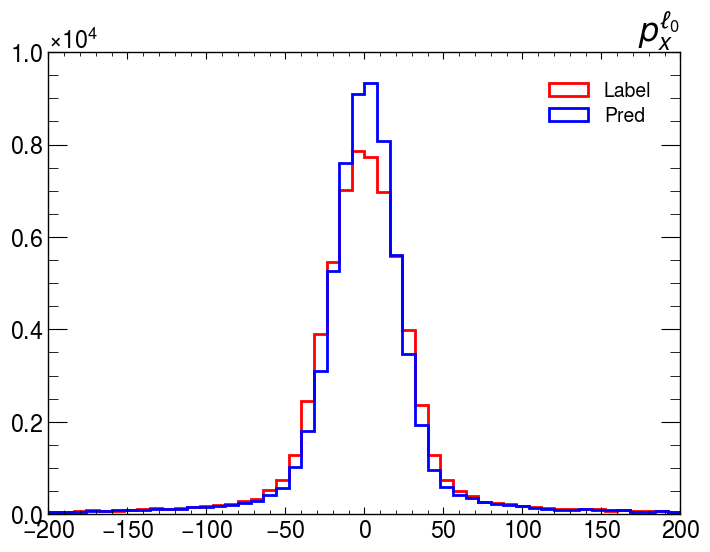

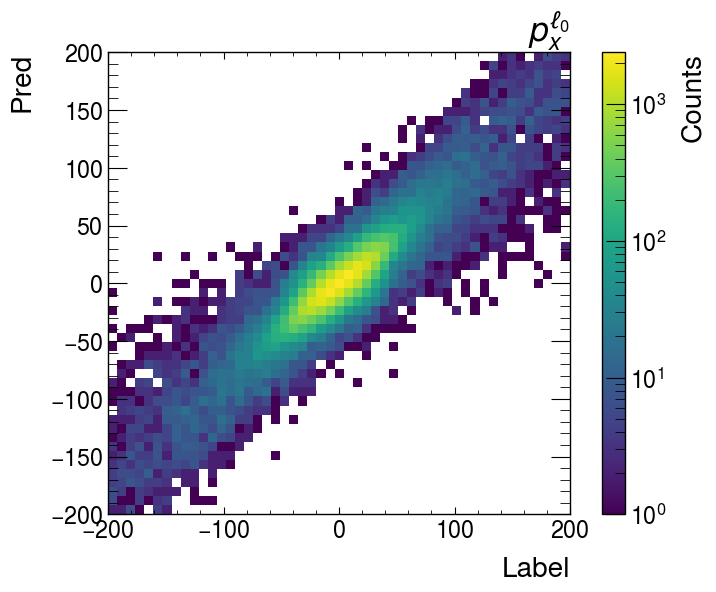

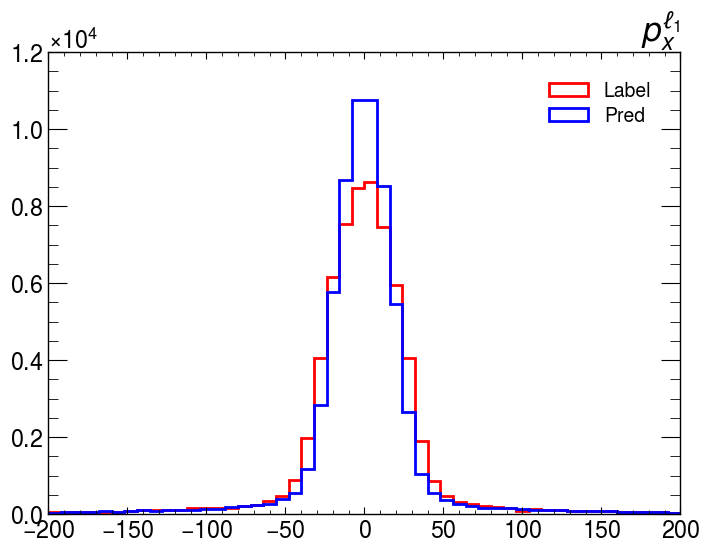

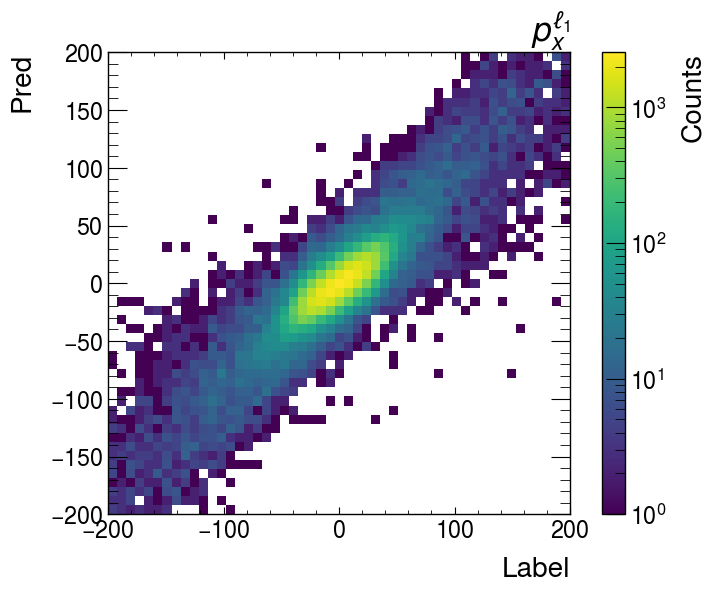

In [35]:
# px

# lead
plt.hist(label_lead_w_px, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_px, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_0}_{x}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_px,
	pred_lead_w_px,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_0}_{x}$", loc='right')
plt.show()

# sublead px
plt.hist(label_sublead_w_px, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_px, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_1}_{x}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_px,
	pred_sublead_w_px,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_1}_{x}$", loc='right')
plt.show()

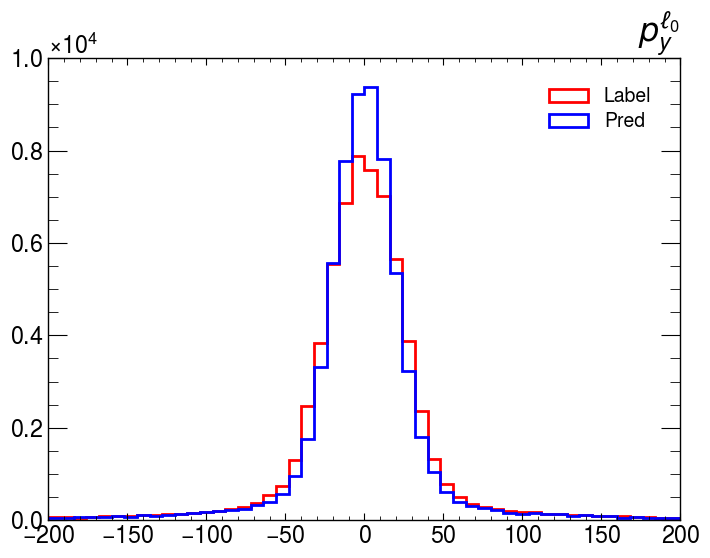

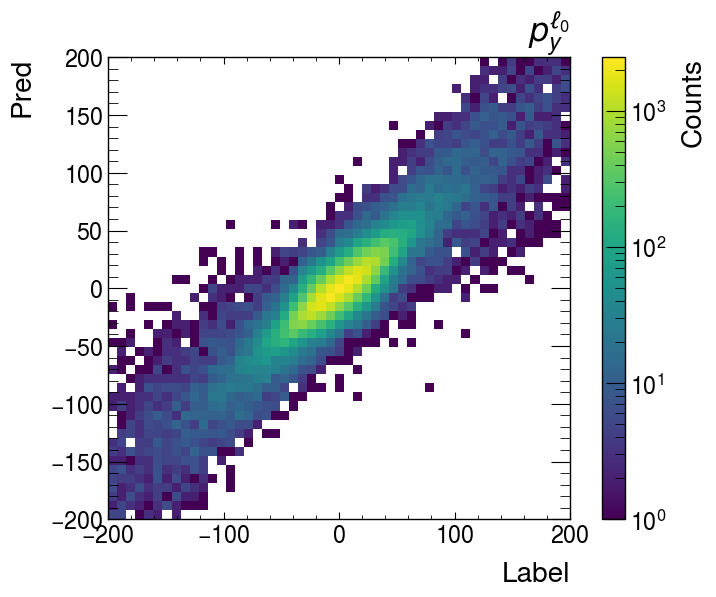

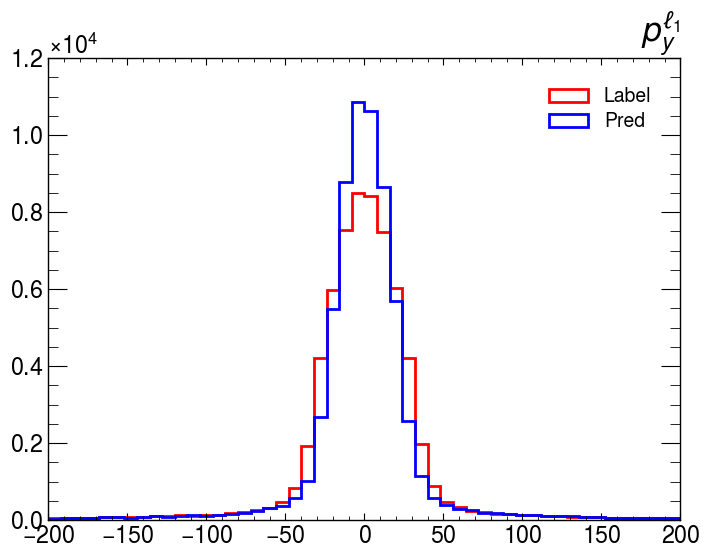

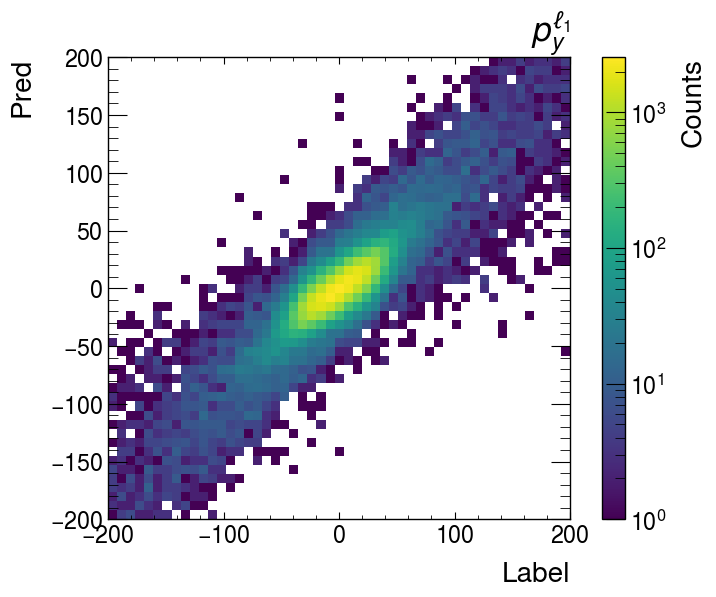

In [36]:
# py

# lead
plt.hist(label_lead_w_py, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_py, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_0}_{y}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_py,
	pred_lead_w_py,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_0}_{y}$", loc='right')
plt.show()

# sublead py
plt.hist(label_sublead_w_py, bins=np.linspace(-200, 200, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_py, bins=np.linspace(-200, 200, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_1}_{y}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_py,
	pred_sublead_w_py,
	bins=(51, 51),
	range=([-200, 200], [-200, 200]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_1}_{y}$", loc='right')
plt.show()

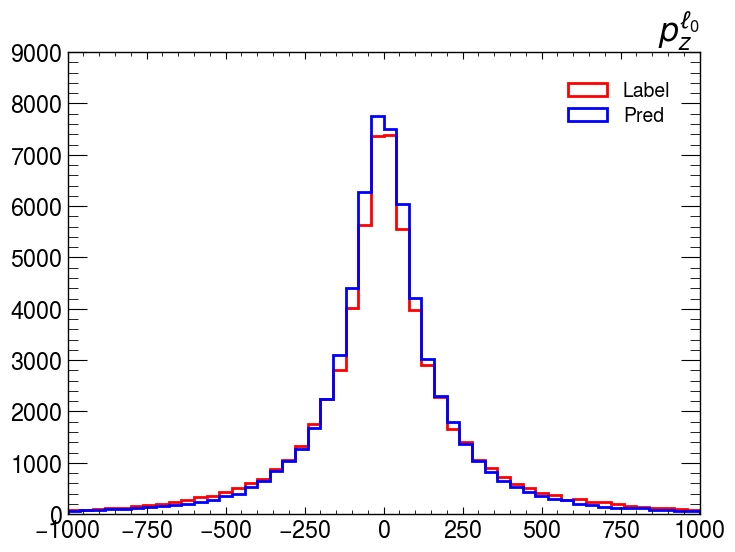

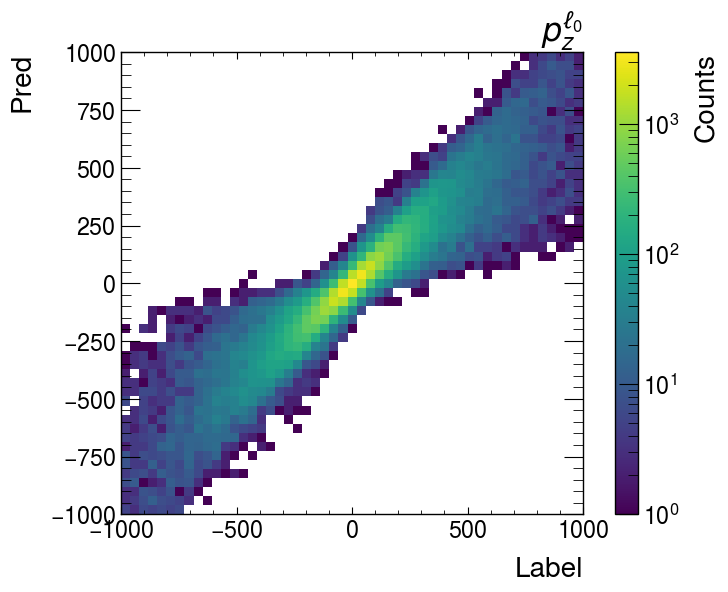

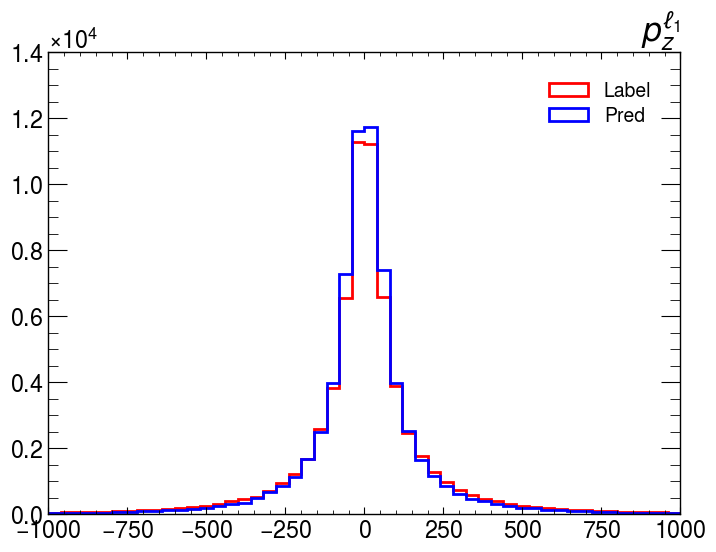

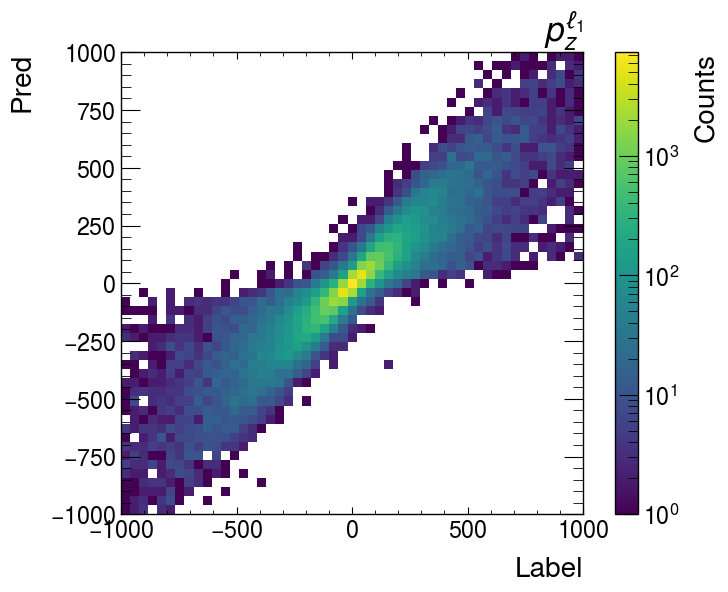

In [37]:
# pz

# lead
plt.hist(label_lead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_0}_{z}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_pz,
	pred_lead_w_pz,
	bins=(51, 51),
	range=([-1000, 1000], [-1000, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_0}_{z}$", loc='right')
plt.show()

# sublead pz
plt.hist(label_sublead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_pz, bins=np.linspace(-1000, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$p^{\ell_1}_{z}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_pz,
	pred_sublead_w_pz,
	bins=(51, 51),
	range=([-1000, 1000], [-1000, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$p^{\ell_1}_{z}$", loc='right')
plt.show()

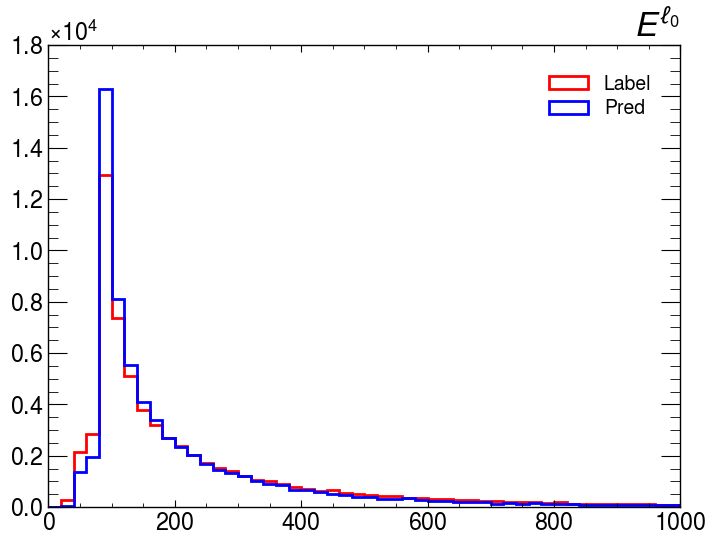

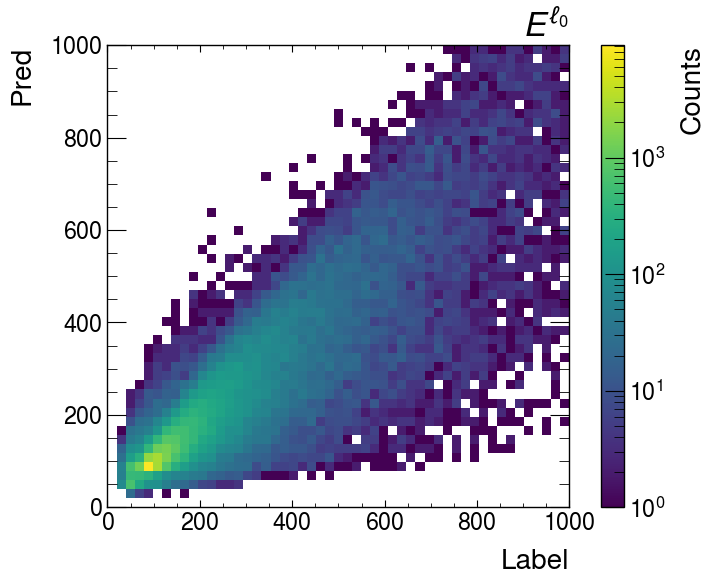

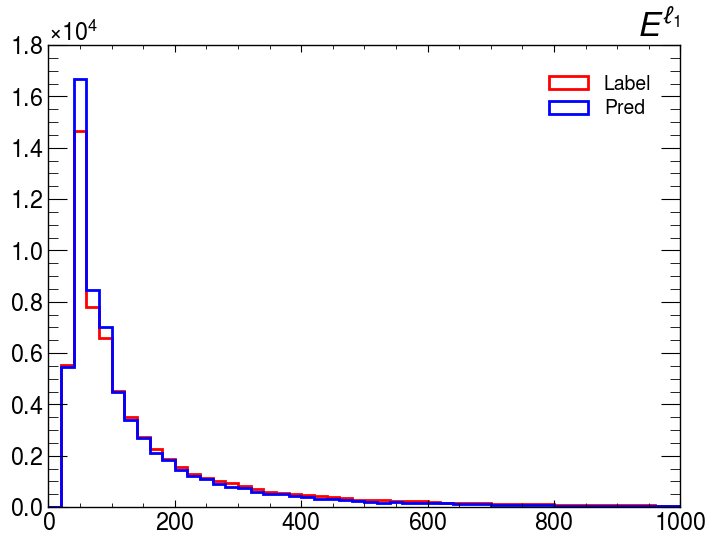

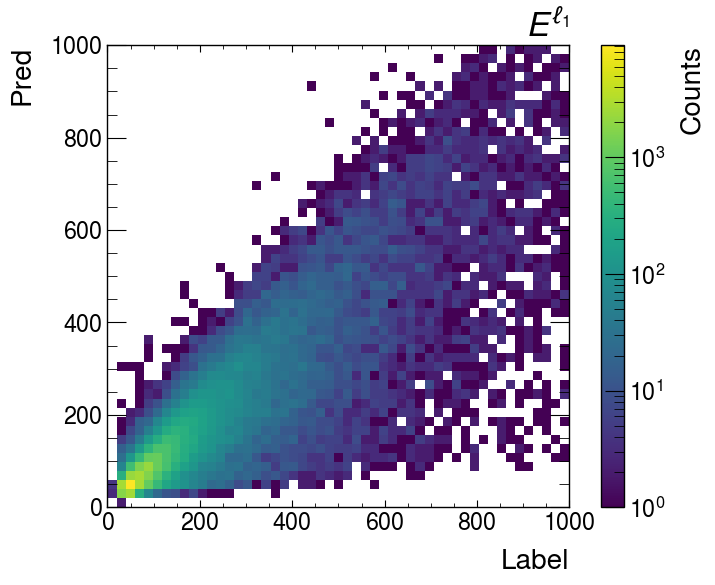

In [38]:
# energy

# lead
plt.hist(label_lead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_lead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$E^{\ell_0}$", loc='right')
plt.show()

plt.hist2d(
	label_lead_w_energy,
	pred_lead_w_energy,
	bins=(51, 51),
	range=([0, 1000], [0, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$E^{\ell_0}$", loc='right')
plt.show()

# sublead energy
plt.hist(label_sublead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Label", histtype="step", linewidth=2, color="red")
plt.hist(pred_sublead_w_energy, bins=np.linspace(0, 1000, 51), label=r"Pred", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.title(r"$E^{\ell_1}$", loc='right')
plt.show()

plt.hist2d(
	label_sublead_w_energy,
	pred_sublead_w_energy,
	bins=(51, 51),
	range=([0, 1000], [0, 1000]),
	cmap="viridis",
	cmin=1,
	norm=LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel(r"Pred")
plt.xlabel(r"Label")
plt.title(r"$E^{\ell_1}$", loc='right')
plt.show()

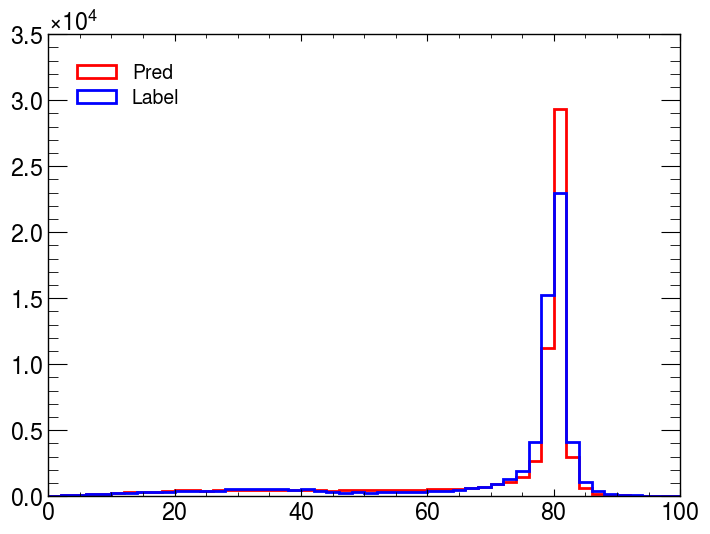

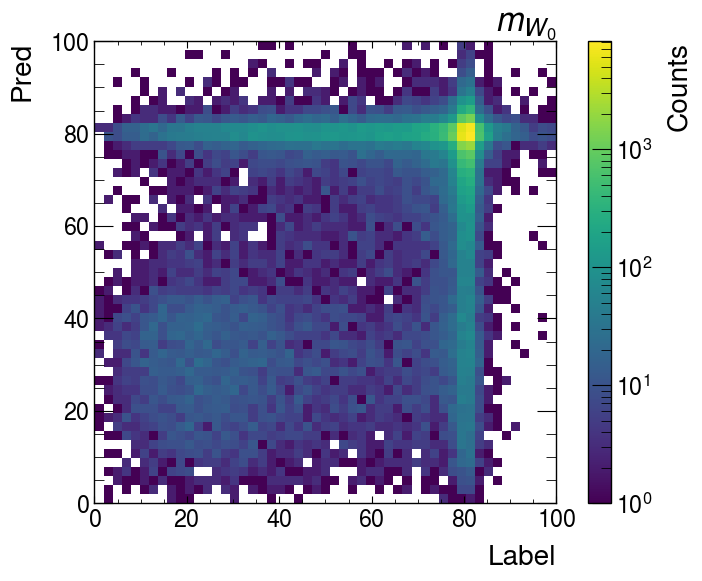

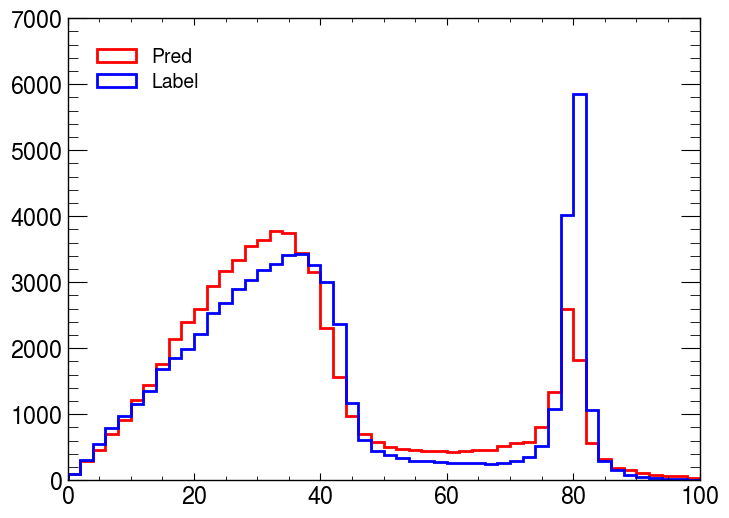

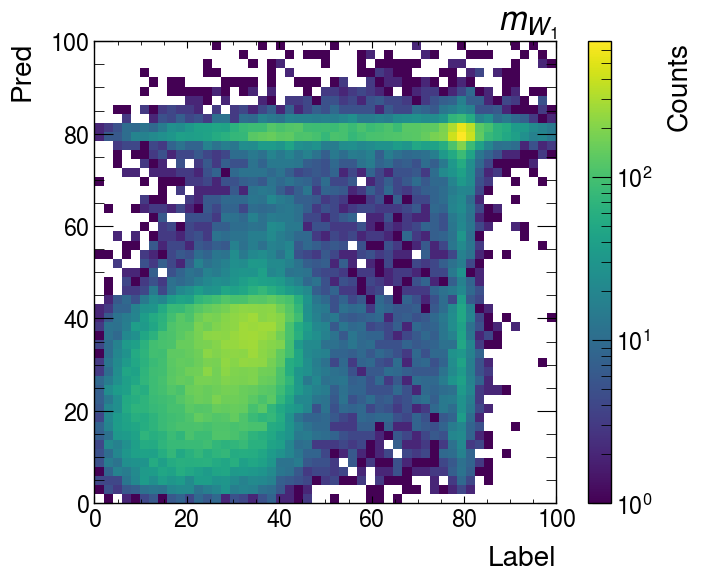

In [39]:
# W inv mass

w_lead_pred = np.sqrt(
	np.square(pred_lead_w_energy)
	- np.square(pred_lead_w_px)
	- np.square(pred_lead_w_py)
	- np.square(pred_lead_w_pz)
)
w_sublead_pred = np.sqrt(
	np.square(pred_sublead_w_energy)
	- np.square(pred_sublead_w_px)
	- np.square(pred_sublead_w_py)
	- np.square(pred_sublead_w_pz)
)
w_lead_label = np.sqrt(
	np.square(label_lead_w_energy)
	- np.square(label_lead_w_px)
	- np.square(label_lead_w_py)
	- np.square(label_lead_w_pz)
)
w_sublead_label = np.sqrt(
	np.square(label_sublead_w_energy)
	- np.square(label_sublead_w_px)
	- np.square(label_sublead_w_py)
	- np.square(label_sublead_w_pz)
)

plt.hist(w_lead_pred, bins=np.linspace(0, 100, 51), label=r"Pred", histtype="step", linewidth=2, color="red")
plt.hist(w_lead_label, bins=np.linspace(0, 100, 51), label=r"Label", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.xlim(0, 100)
plt.show()

plt.hist2d(
	w_lead_pred,
	w_lead_label,
	bins=(51, 51),
	range=([0, 100], [0, 100]),
	cmap="viridis",
	cmin=1,
	norm = LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel("Pred")
plt.xlabel("Label")
plt.title(r"$m_{W_0}$", loc='right')
plt.show()


plt.hist(w_sublead_pred, bins=np.linspace(0, 100, 51), label="Pred", histtype="step", linewidth=2, color="red")
plt.hist(w_sublead_label, bins=np.linspace(0, 100, 51), label="Label", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.xlim(0, 100)
plt.show()

plt.hist2d(
	w_sublead_pred,
	w_sublead_label,
	bins=(51, 51),
	range=([0, 100], [0, 100]),
	cmap="viridis",
	cmin=1,
	norm = LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel("Pred")
plt.xlabel("Label")
plt.title(r"$m_{W_1}$", loc='right')
plt.show()

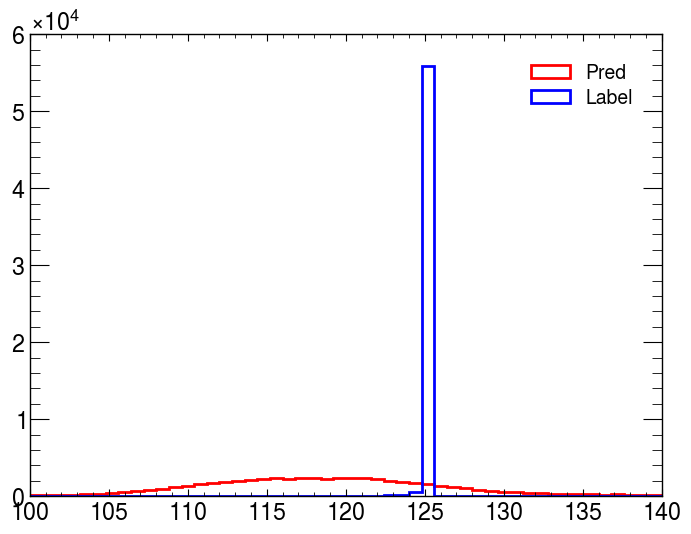

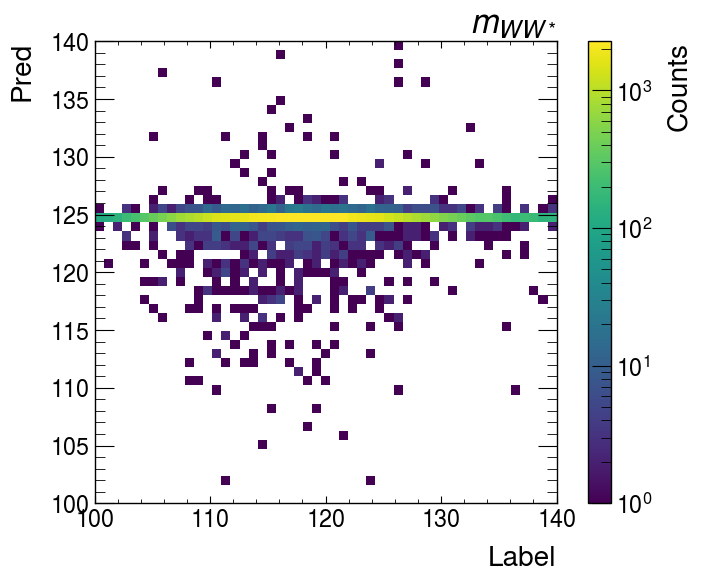

In [40]:
# WW* inv mass
ww_pred = np.sqrt(
	np.square(pred_lead_w_energy + pred_sublead_w_energy)
	- np.square(pred_lead_w_px + pred_sublead_w_px)
	- np.square(pred_lead_w_py + pred_sublead_w_py)
	- np.square(pred_lead_w_pz + pred_sublead_w_pz)
)
ww_label = np.sqrt(
	np.square(label_lead_w_energy + label_sublead_w_energy)
	- np.square(label_lead_w_px + label_sublead_w_px)
	- np.square(label_lead_w_py + label_sublead_w_py)
	- np.square(label_lead_w_pz + label_sublead_w_pz)
)
plt.hist(ww_pred, bins=np.linspace(100, 140, 51), label="Pred", histtype="step", linewidth=2, color="red")
plt.hist(ww_label, bins=np.linspace(100, 140, 51), label="Label", histtype="step", linewidth=2, color="blue")
plt.legend()
plt.xlim(100, 140)
plt.show()

plt.hist2d(
	ww_pred,
	ww_label,
	bins=(51, 51),
	range=([100, 140], [100, 140]),
	cmap="viridis",
	cmin=1,
	norm = LogNorm()
)
plt.colorbar(label="Counts")
plt.gca().set_aspect("equal", adjustable="box")
plt.ylabel("Pred")
plt.xlabel("Label")
plt.title(r"$m_{WW^\ast}$", loc='right')
plt.show()

In [41]:
def Bij(particles):
    # Ensure ROOT is properly initialized
    ROOT.gROOT.SetBatch(True)

    def cglmp(z_xp, z_xn, z_yp, z_yn):
        """
        This is a function to calculate Bij (CGLMP values).
        :param z_xp: Angle (xi) between positive lepton and x-axis.
        :param z_xn: Angle (xi) between negative lepton and x-axis.
        :param z_yp: Angle (xi) between positive lepton and y-axis.
        :param z_xn: Angle (xi) between negative lepton and y-axis.
        """
        # count expectation value, use (27) in Alan's paper
        tr_a = (np.divide(8, np.sqrt(3))) * (z_xp * z_xn + z_yp * z_yn)
        tr_b = (
            25
            * (np.square(z_xp) - np.square(z_yp))
            * (np.square(z_xn) - np.square(z_yn))
        )
        tr_c = 100 * (z_xp * z_yp * z_xn * z_yn)
        tr = tr_a + tr_b + tr_c

        return tr

    WpBoson = TLorentzVector(*particles[:4]) # (px, py, pz, energy)
    WpLepton = TLorentzVector(*particles[4:8])
    WnBoson = TLorentzVector(*particles[8:12])
    WnLepton = TLorentzVector(*particles[12:16])
    lab_lp = np.array([WpLepton.X(), WpLepton.Y(), WpLepton.Z(), WpLepton.T()])
    lab_ln = np.array([WnLepton.X(), WnLepton.Y(), WnLepton.Z(), WnLepton.T()])
    
    # construct Higgs 4-vector
    Higgs = WpBoson + WnBoson

    # construct a moving orthogonal basis (k,r,n)
    Beam_p = TLorentzVector(0, 0, 1, 1)  # spatial-axis

    # define boost vector
    Higgsb = Higgs.BoostVector()

    # (1) performs a boost transformation from the rod frame to the rawal one.
    # Perform boost transformation from the rod frame to the rawal one
    for vec in [WpBoson, WpLepton, WnBoson, WnLepton, Beam_p]:
        vec.Boost(-Higgsb)
    
    # momentum in Higgs rest frame - extract components properly
    higgs_rest_WpLepton = np.array([WpLepton.X(), WpLepton.Y(), WpLepton.Z(), WpLepton.T()])
    higgs_rest_WnLepton = np.array([WnLepton.X(), WnLepton.Y(), WnLepton.Z(), WnLepton.T()])

    # 2. Define (k,r,n) -> definitions are in Alan's paper
    k_per = TVector3(WpBoson.X(), WpBoson.Y(), WpBoson.Z())
    p_per = TVector3(Beam_p.X(), Beam_p.Y(), Beam_p.Z())  # in the Higgs rest frame
    k = k_per.Unit()  # normalized -> unit vector
    p = p_per.Unit()
    y = p.Dot(k)
    r_length = np.sqrt(1 - y * y)
    r = (1 / r_length) * (p - y * k)
    n = (1 / r_length) * (p.Cross(k))  # (1/sin)*sin = 1 -> unit vector

    # 3. Further boost to W+ and W- frame respectively
    WpkBoost = WpBoson.BoostVector()
    WpBoson.Boost(-WpkBoost)
    WpLepton.Boost(-WpkBoost)
    WnkBoost = WnBoson.BoostVector()
    WnBoson.Boost(-WnkBoost)
    WnLepton.Boost(-WnkBoost)

    # 4. Map all particle to (k,r,n) frame
    WpLp = WpLepton.Vect()  # momentum in (k,r,n)
    WnLp = WnLepton.Vect()
    # Mapping to n-r-k basis
    WpLp_k = TLorentzVector(WpLp.Dot(n), WpLp.Dot(r), WpLp.Dot(k), WpLepton.E())
    WnLp_k = TLorentzVector(WnLp.Dot(n), WnLp.Dot(r), WnLp.Dot(k), WnLepton.E())

    # 5. Calculate directional cosines
    # directional cosine from Wp
    WpLp_Vect_Mag = WpLp_k.Vect().Mag()
    cos_n_join_p = np.divide(WpLp_k.X(), WpLp_Vect_Mag)
    cos_r_join_p = np.divide(WpLp_k.Y(), WpLp_Vect_Mag)
    cos_k_join_p = np.divide(WpLp_k.Z(), WpLp_Vect_Mag)
    # directional cosine from Wn
    WnLp_Vect_Mag = WnLp_k.Vect().Mag()
    cos_n_join_n = np.divide(WnLp_k.X(), WnLp_Vect_Mag)
    cos_r_join_n = np.divide(WnLp_k.Y(), WnLp_Vect_Mag)
    cos_k_join_n = np.divide(WnLp_k.Z(), WnLp_Vect_Mag)

    # 6. Calculate Bij (CGLMP values)
    B_xy = cglmp(cos_n_join_p, cos_n_join_n, cos_r_join_p, cos_r_join_n)
    B_yz = cglmp(cos_r_join_p, cos_r_join_n, cos_k_join_p, cos_k_join_n)
    B_zx = cglmp(cos_n_join_p, cos_n_join_n, cos_k_join_p, cos_k_join_n)

    # Also fix the W rest frame arrays to extract components properly
    w_rest_WpLepton = np.array([WpLepton.X(), WpLepton.Y(), WpLepton.Z(), WpLepton.T()])
    w_rest_WnLepton = np.array([WnLepton.X(), WnLepton.Y(), WnLepton.Z(), WnLepton.T()])

    return (
        np.array([B_xy, B_yz, B_zx]),
        np.array([cos_n_join_p, cos_r_join_p, cos_k_join_p]),
        np.array([cos_n_join_n, cos_r_join_n, cos_k_join_n]),
        lab_lp,
        lab_ln,
        higgs_rest_WpLepton,
        higgs_rest_WnLepton,
        w_rest_WpLepton,
        w_rest_WnLepton,
    )


def result_generator(particles):
    with multiprocessing.Pool(WORKERS) as pool:
        # Retrieve the output from the pool
        results = list(pool.map(Bij, particles))

    # Unpack the results
    bij, xi_p, xi_n, lab_lp, lab_ln, h_rest_lp, h_rest_ln, w_rest_lp, w_rest_ln = zip(*results)

    bij = np.vstack(bij)  # Flatten the nested array
    xi_p = np.vstack(xi_p)
    xi_n = np.vstack(xi_n)
    lab_lp = np.vstack(lab_lp)
    lab_ln = np.vstack(lab_ln)
    h_rest_lp = np.vstack(h_rest_lp)
    h_rest_ln = np.vstack(h_rest_ln)
    w_rest_lp = np.vstack(w_rest_lp)
    w_rest_ln = np.vstack(w_rest_ln)
    mask = np.any(np.isnan(bij), axis=1)
    print("Number of NaN values in bij:", np.sum(mask))
    return (
        bij,
        xi_p,
        xi_n,
        mask,
        lab_lp,
        lab_ln,
        h_rest_lp,
        h_rest_ln,
        w_rest_lp,
        w_rest_ln,
    )

In [44]:
# mc20 truth

mc20_true_obs_kin = np.column_stack(
    (
        truth_lead_lep["px"],
        truth_lead_lep["py"],
        truth_lead_lep["pz"],
        truth_lead_lep["energy"],
        truth_sublead_lep["px"],
        truth_sublead_lep["py"],
        truth_sublead_lep["pz"],
        truth_sublead_lep["energy"],
        truth_lead_nu["px"] + truth_sublead_nu["px"],
        truth_lead_nu["py"] + truth_sublead_nu["py"],
    )
)
# trim the data
print("mc20 (true) obs_kin shape:", mc20_true_obs_kin.shape)
mc20_true_obs_kin = mc20_true_obs_kin[PRE_CUT]
print("After selection ...\nmc20 (true) obs_kin shape:", mc20_true_obs_kin.shape)

mc20 (true) obs_kin shape: (2963488, 10)
After selection ...
mc20 (true) obs_kin shape: (1460585, 10)


In [46]:
# mc20 truth (car)

mc20_ll_obs_kin = np.column_stack(
    (
        truth_lead_lep_ll["px"],
        truth_lead_lep_ll["py"],
        truth_lead_lep_ll["pz"],
        truth_lead_lep_ll["energy"],
        truth_sublead_lep_ll["px"],
        truth_sublead_lep_ll["py"],
        truth_sublead_lep_ll["pz"],
        truth_sublead_lep_ll["energy"],
        truth_lead_nu_ll["px"] + truth_sublead_nu_ll["px"],
        truth_lead_nu_ll["py"] + truth_sublead_nu_ll["py"],
    )
)

print("mc20 (car) obs_kin shape:", mc20_ll_obs_kin.shape)
mc20_ll_obs_kin = mc20_ll_obs_kin[PRE_CUT_LL]
print("After selection ...\nmc20 (car) obs_kin shape:", mc20_ll_obs_kin.shape)

mc20 (car) obs_kin shape: (1497625, 10)
After selection ...
mc20 (car) obs_kin shape: (649710, 10)


In [57]:
# predictions from the model trained with mc16 data

mc20_sm_pred_y = model.predict(mc20_true_obs_kin[:100_000])  # ~truth
mc20_ll_pred_y = model.predict(mc20_ll_obs_kin[:100_000])  # ~truth_ll

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 912us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [58]:
"""
CGLMP and xi:

ground truth for LL
"""

mc20_particles = np.concatenate(
    [
        w_lead_p4_sm[PRE_CUT][:100_000],
        truth_lead_lep_p4[PRE_CUT][:100_000],
        w_sublead_p4_sm[PRE_CUT][:100_000],
        truth_sublead_lep_p4[PRE_CUT][:100_000],
    ],
    axis=1,
)
(
    truth_bij, 
    truth_xi_p, 
    truth_xi_n, 
    truth_mask,
    truth_lab_lp, 
    truth_lab_ln,
    truth_h_rest_lp, 
    truth_h_rest_ln, 
    truth_w_rest_lp, 
    truth_w_rest_ln
) = result_generator(mc20_particles)

Number of NaN values in bij: 0


In [59]:
"""
CGLMP and xi:

ground truth for LL
"""

mc20_particles = np.concatenate(
    [
        w_lead_p4[PRE_CUT_LL][:100_000],
        truth_lead_lep_ll_p4[PRE_CUT_LL][:100_000],
        w_sublead_p4[PRE_CUT_LL][:100_000],
        truth_sublead_lep_ll_p4[PRE_CUT_LL][:100_000],
    ],
    axis=1,
)
(
    truth_bij_ll, 
    truth_xi_p_ll, 
    truth_xi_n_ll, 
    truth_mask_ll,
    truth_lab_lp_ll, 
    truth_lab_ln_ll,
    truth_h_rest_lp_ll, 
    truth_h_rest_ln_ll, 
    truth_w_rest_lp_ll, 
    truth_w_rest_ln_ll
) = result_generator(mc20_particles)

Number of NaN values in bij: 0


In [60]:
"""
CGLMP and xi:

[Use for comapring the LL results]
pred(SM) with truth lep
"""

mc20_particles = np.concatenate(
    [
        mc20_sm_pred_y[:, 0:4],
        truth_lead_lep_ll_p4[PRE_CUT_LL][:100_000],
        mc20_sm_pred_y[:, 4:8],
        truth_sublead_lep_ll_p4[PRE_CUT_LL][:100_000],
    ],
    axis=1,
)
(
    bij, 
    xi_p, 
    xi_n, 
    mask,
    lab_lp, 
    lab_ln, 
    h_rest_lp, 
    h_rest_ln, 
    w_rest_lp, 
    w_rest_ln,
    
) = result_generator(mc20_particles)

Number of NaN values in bij: 0


In [62]:
"""
CGLMP and xi:

[Use for comapring the LL results]
pred(SM) with truth lep
"""

mc20_particles = np.concatenate(
    [
        mc20_sm_pred_y[:, 0:4],
        truth_lead_lep_p4[PRE_CUT][:100_000],
        mc20_sm_pred_y[:, 4:8],
        truth_sublead_lep_p4[PRE_CUT][:100_000],
    ],
    axis=1,
)
(
    bij, 
    xi_p, 
    xi_n, 
    mask,
    lab_lp, 
    lab_ln, 
    h_rest_lp, 
    h_rest_ln, 
    w_rest_lp, 
    w_rest_ln,
    
) = result_generator(mc20_particles)

Number of NaN values in bij: 0


In [65]:
"""
CGLMP and xi:

pred(LL) with car lep
"""


mc20_particles = np.concatenate(
    [
        mc20_ll_pred_y[:, 0:4],
        truth_lead_lep_ll_p4[PRE_CUT_LL][:100_000],
        mc20_ll_pred_y[:, 4:8],
        truth_sublead_lep_ll_p4[PRE_CUT_LL][:100_000],
    ],
    axis=1,
)
(
    bij_ll, 
    xi_p_ll, 
    xi_n_ll, 
    mask_ll, 
    lab_lp_ll, 
    lab_ln_ll, 
    h_rest_lp_ll, 
    h_rest_ln_ll, 
    w_rest_lp_ll, 
    w_rest_ln_ll
) = result_generator(mc20_particles)

Number of NaN values in bij: 0


In [66]:
# trim out nan values 

mask = ~truth_mask & ~truth_mask_ll & ~mask & ~mask_ll

In [67]:
# variables for plotting
bij = bij[mask]
bij_ll = bij_ll[mask]
xi_p = xi_p[mask]
xi_p_ll = xi_p_ll[mask]
xi_n = xi_n[mask]
xi_n_ll = xi_n_ll[mask]
lab_lp = lab_lp[mask]
lab_ln = lab_ln[mask]
lab_lp_ll = lab_lp_ll[mask]
lab_ln_ll = lab_ln_ll[mask]
h_rest_lp = h_rest_lp[mask]
h_rest_ln = h_rest_ln[mask]
h_rest_lp_ll = h_rest_lp_ll[mask]
h_rest_ln_ll = h_rest_ln_ll[mask]
w_rest_lp = w_rest_lp[mask]
w_rest_ln = w_rest_ln[mask]
w_rest_lp_ll = w_rest_lp_ll[mask]
w_rest_ln_ll = w_rest_ln_ll[mask]


truth_bij = truth_bij[mask]
truth_bij_ll = truth_bij_ll[mask]
truth_xi_p = truth_xi_p[mask]
truth_xi_p_ll = truth_xi_p_ll[mask]
truth_xi_n = truth_xi_n[mask]
truth_xi_n_ll = truth_xi_n_ll[mask]
truth_lab_lp = truth_lab_lp[mask]
truth_lab_ln = truth_lab_ln[mask]
truth_lab_lp_ll = truth_lab_lp_ll[mask]
truth_lab_ln_ll = truth_lab_ln_ll[mask]
truth_h_rest_lp = truth_h_rest_lp[mask]
truth_h_rest_ln = truth_h_rest_ln[mask]
truth_h_rest_lp_ll = truth_h_rest_lp_ll[mask]
truth_h_rest_ln_ll = truth_h_rest_ln_ll[mask]
truth_w_rest_lp = truth_w_rest_lp[mask]
truth_w_rest_ln = truth_w_rest_ln[mask]
truth_w_rest_lp_ll = truth_w_rest_lp_ll[mask]
truth_w_rest_ln_ll = truth_w_rest_ln_ll[mask]

LL (pred ~ truth_ll) vs SM (pred ~ truth)


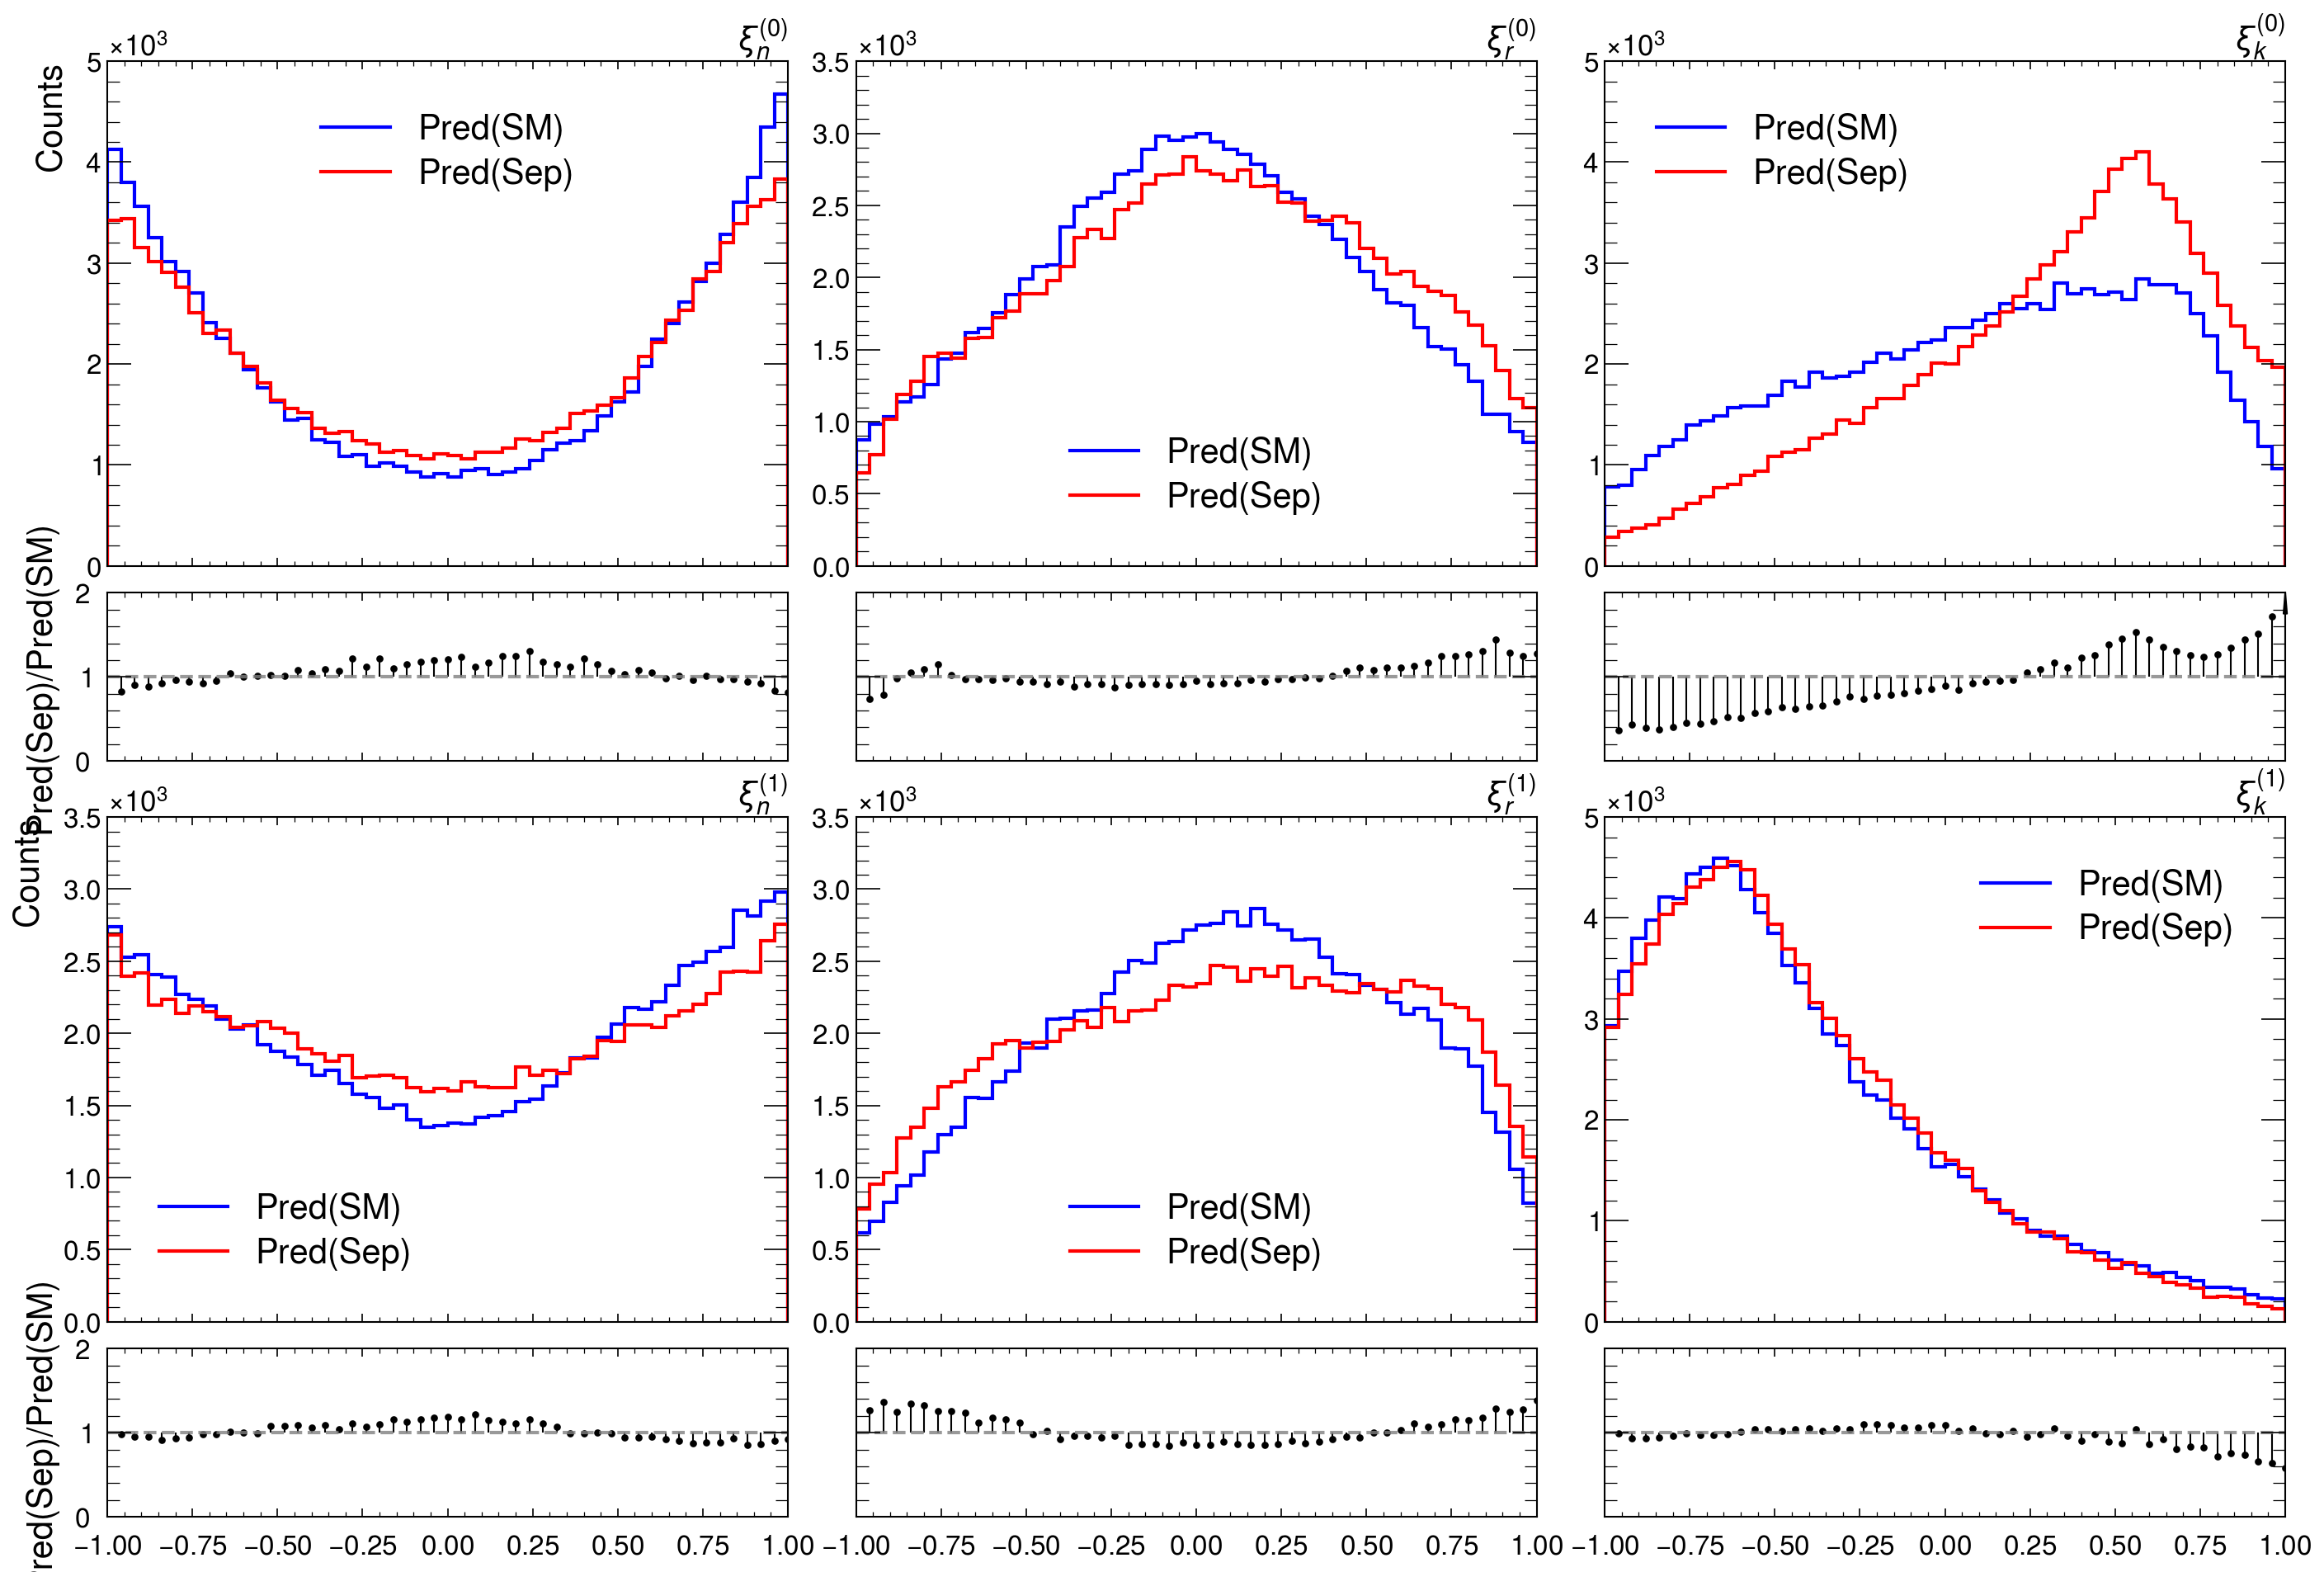

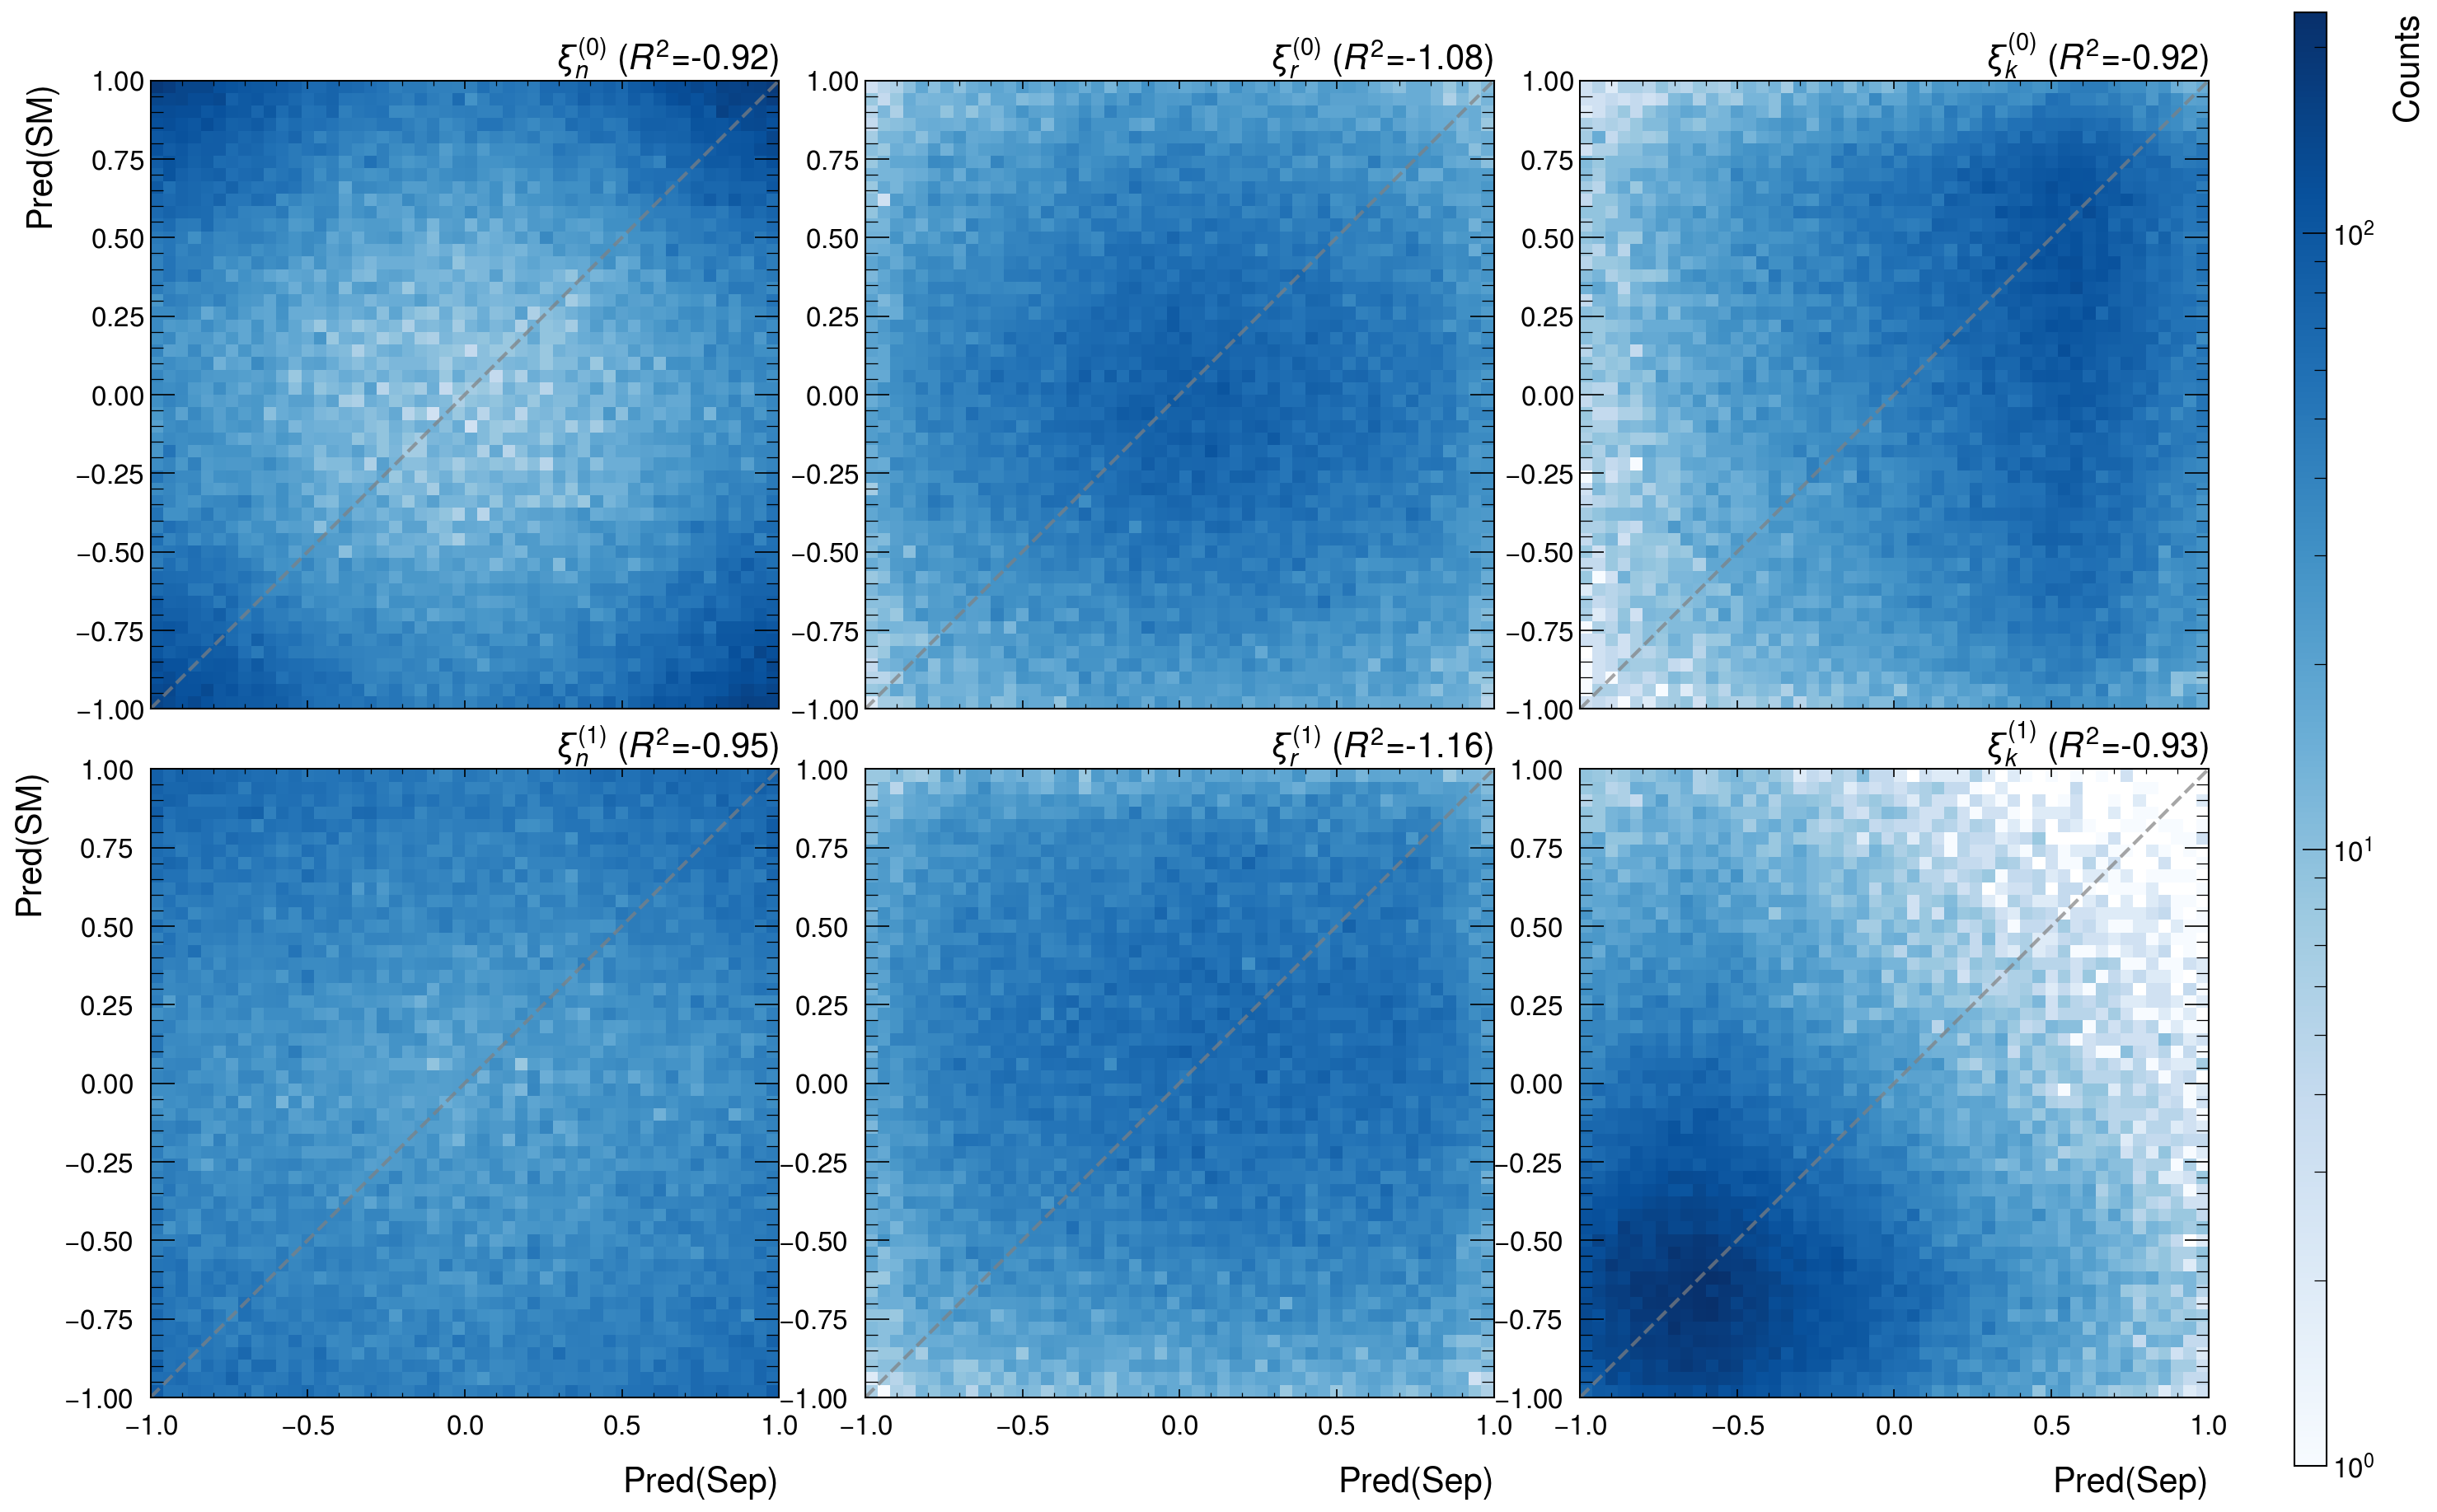

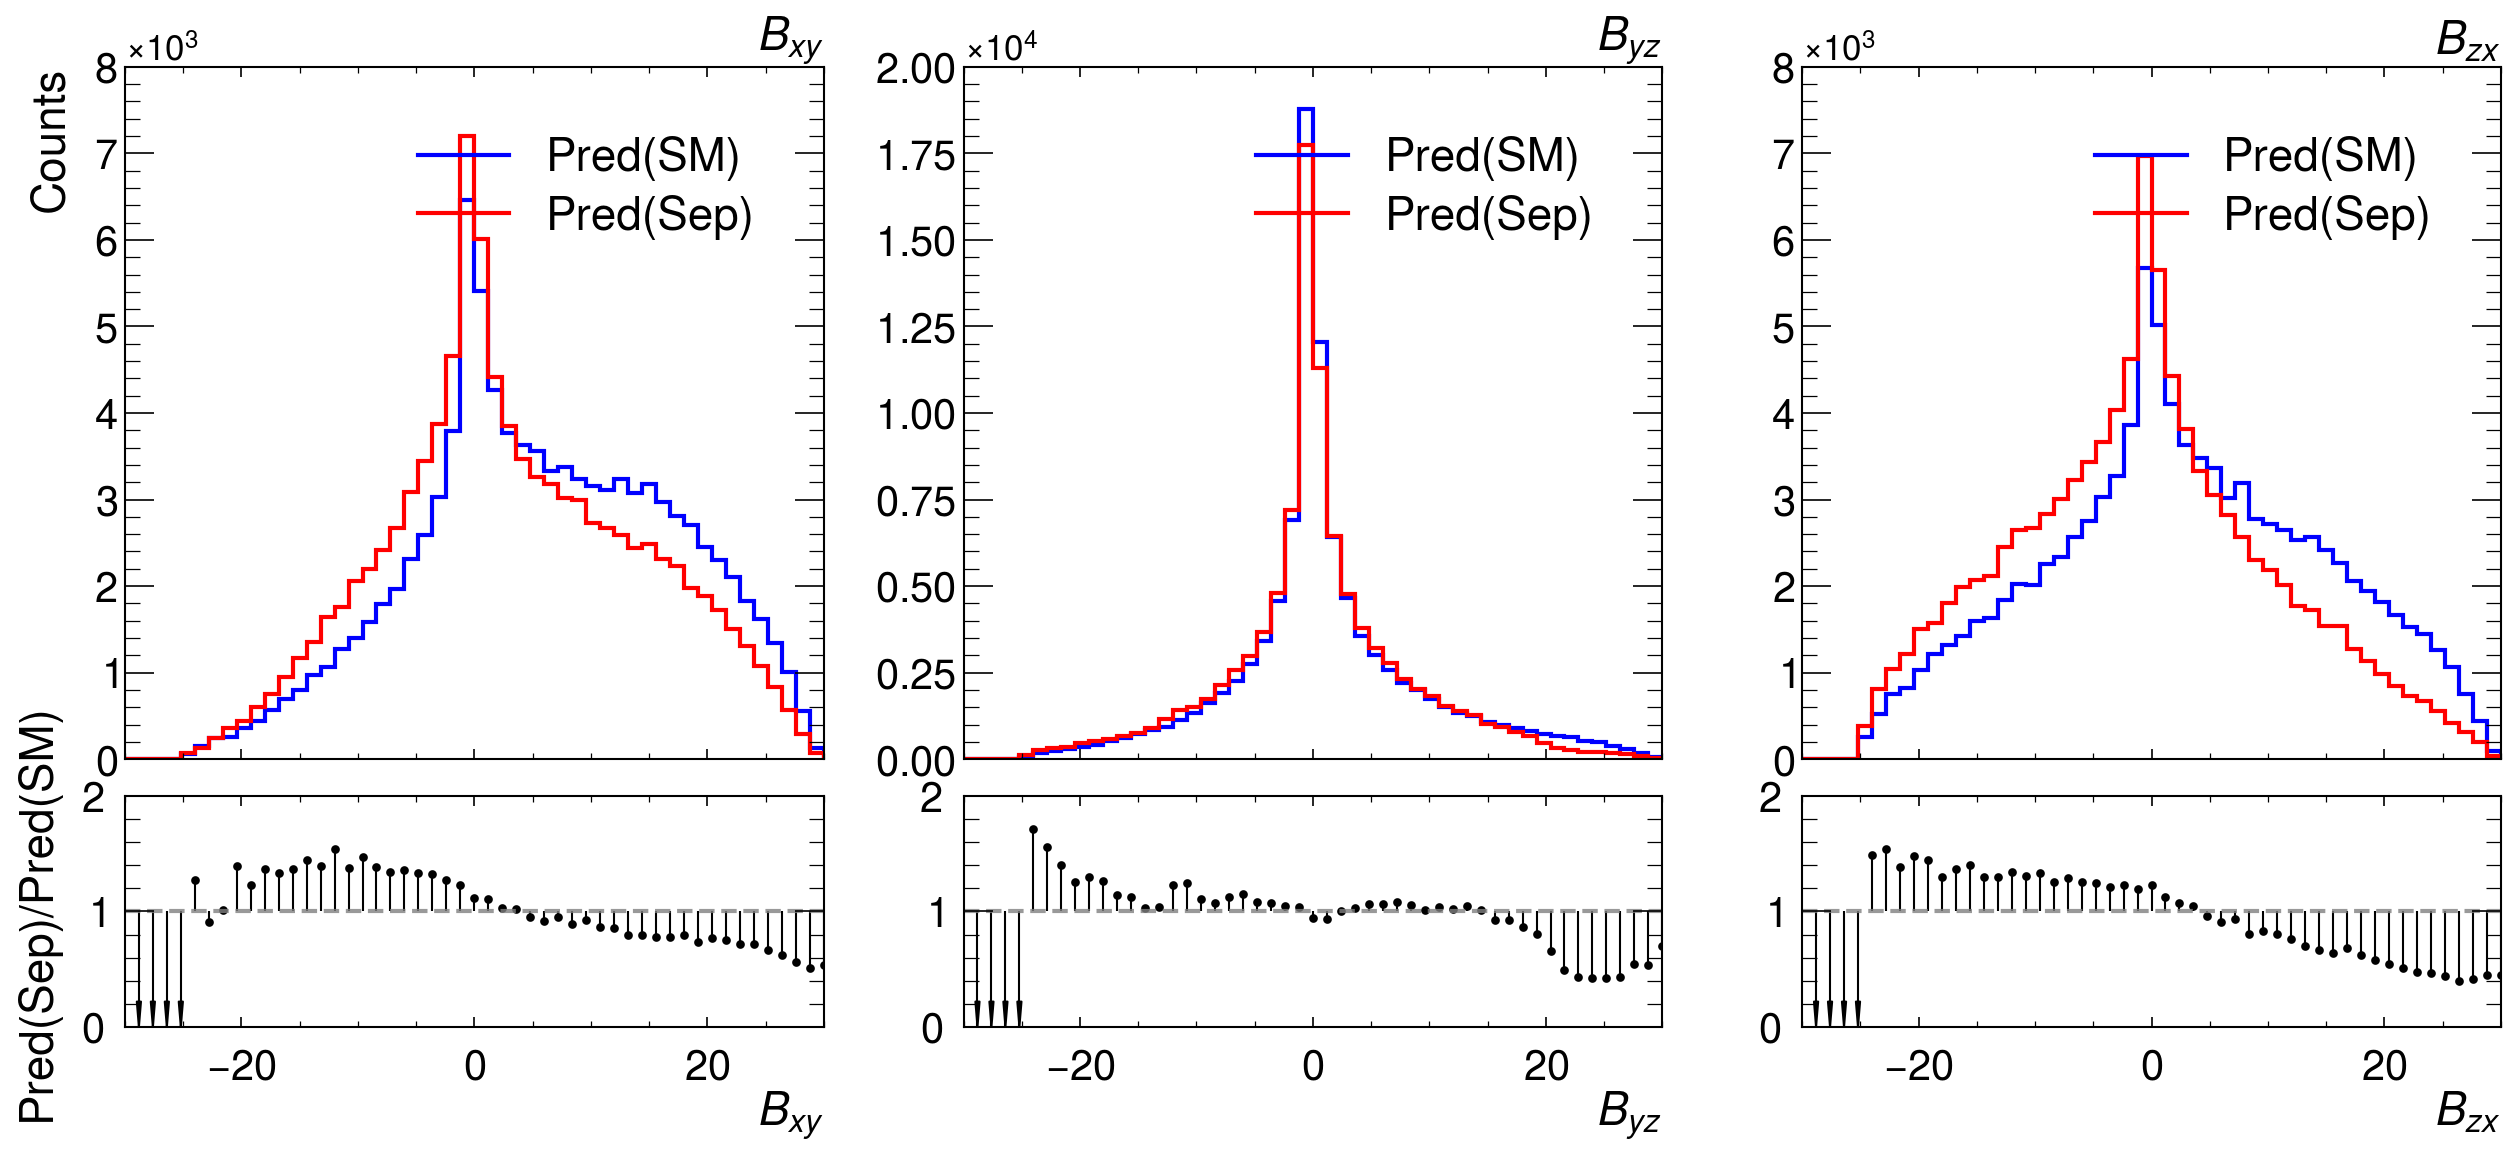


Bxy -> EMD:2.472, kl: 0.534 with SM mean:5.837, Sep mean 3.365
Byz -> EMD:0.775, kl: 0.231 with SM mean:1.198, Sep mean 0.423
Bzx -> EMD:3.419, kl: 0.982 with SM mean:2.691, Sep mean -0.729



In [68]:
"""
Xi comparison:

Pred LL vs pred SM 
"""

print("LL (pred ~ truth_ll) vs SM (pred ~ truth)")

# xi
xi_plot_true = [
    xi_p[:, 0],
    xi_p[:, 1],
    xi_p[:, 2],
    xi_n[:, 0],
    xi_n[:, 1],
    xi_n[:, 2],
]
xi_plot_pred = [
    xi_p_ll[:, 0],
    xi_p_ll[:, 1],
    xi_p_ll[:, 2],
    xi_n_ll[:, 0],
    xi_n_ll[:, 1],
    xi_n_ll[:, 2],
]
xi_plot_ranges = [[-1, 1]] * 6
xi_plot_labels = [
    r"$\xi^{(0)}_{n}$",
    r"$\xi^{(0)}_{r}$",
    r"$\xi^{(0)}_{k}$",
    r"$\xi^{(1)}_{n}$",
    r"$\xi^{(1)}_{r}$",
    r"$\xi^{(1)}_{k}$",
]
plot.hist_1d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    legend_lst=["Pred(Sep)", "Pred(SM)"],
    ranges=xi_plot_ranges,
    xlabel="",
)
plot.hist_2d_grid(
    xi_plot_true,
    xi_plot_pred,
    title=xi_plot_labels,
    ranges=xi_plot_ranges,
    xlabel="Pred(Sep)",
    ylabel="Pred(SM)",
)

# bij
bij_plot_true = [
    bij[:, 0],
    bij[:, 1],
    bij[:, 2],
]
bij_plot_pred = [
    bij_ll[:, 0],
    bij_ll[:, 1],
    bij_ll[:, 2],
]
bij_plot_ranges = [[-30, 30]] * 3
bij_plot_labels = [
    r"$B_{xy}$",
    r"$B_{yz}$",
    r"$B_{zx}$",
]

plot.hist_1d3plot(
    bij_plot_true,
    bij_plot_pred,
    ranges=bij_plot_ranges,
    xlabel=bij_plot_labels,
    title=bij_plot_labels,
    row1_ylabel="Counts",
    row1_legend=["Pred(Sep)", "Pred(SM)"],
    xpad=1,
)

emd = [
    sp.stats.wasserstein_distance(bij[:, i], bij_ll[:, i]) for i in range(3)
]

kl_lst = []
for i in range(3):
    # Create histograms
    p, bin_edges = np.histogram(bij[..., i], bins=101, density=True)
    q, _ = np.histogram(bij_ll[..., i], bins=bin_edges, density=True)

    # Normalize histograms
    kl = np.sum(sp.special.kl_div(p, q+1e-10))
    kl_lst.append(kl)
    
mean_true = [np.mean(bij[:, i]) for i in range(3)]
mean_ll = [np.mean(bij_ll[:, i]) for i in range(3)]

print(
    rf"""
Bxy -> EMD:{emd[0]:.3f}, kl: {10*kl_lst[0]:.3f} with SM mean:{mean_true[0]:.3f}, Sep mean {mean_ll[0]:.3f}
Byz -> EMD:{emd[1]:.3f}, kl: {10*kl_lst[1]:.3f} with SM mean:{mean_true[1]:.3f}, Sep mean {mean_ll[1]:.3f}
Bzx -> EMD:{emd[2]:.3f}, kl: {10*kl_lst[2]:.3f} with SM mean:{mean_true[2]:.3f}, Sep mean {mean_ll[2]:.3f}
"""
)

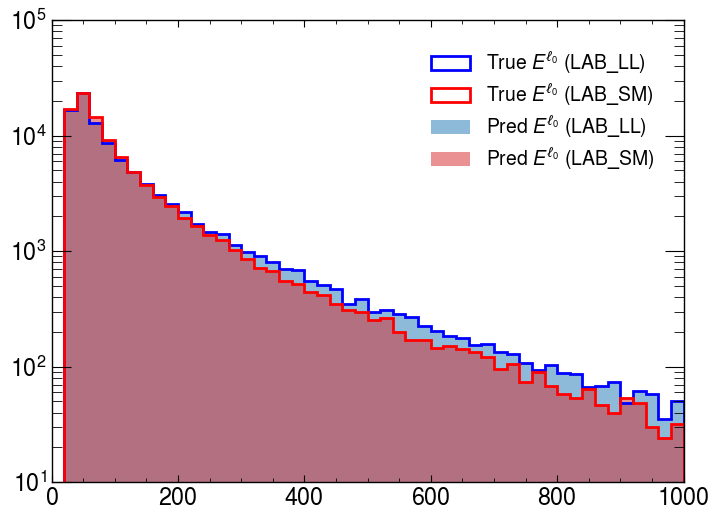

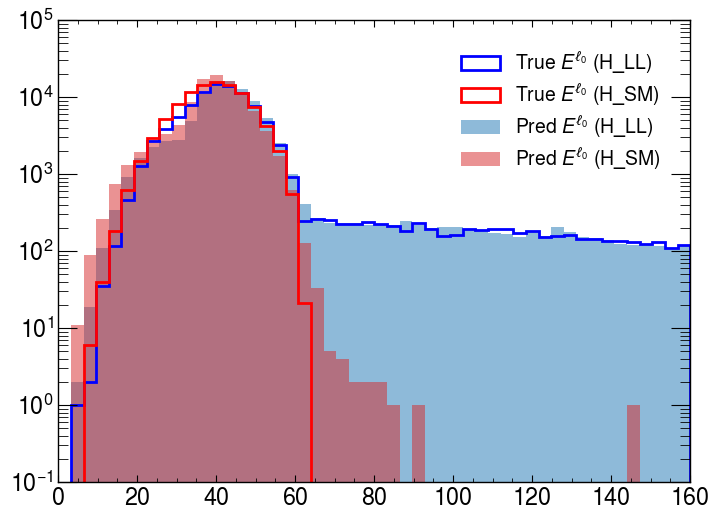

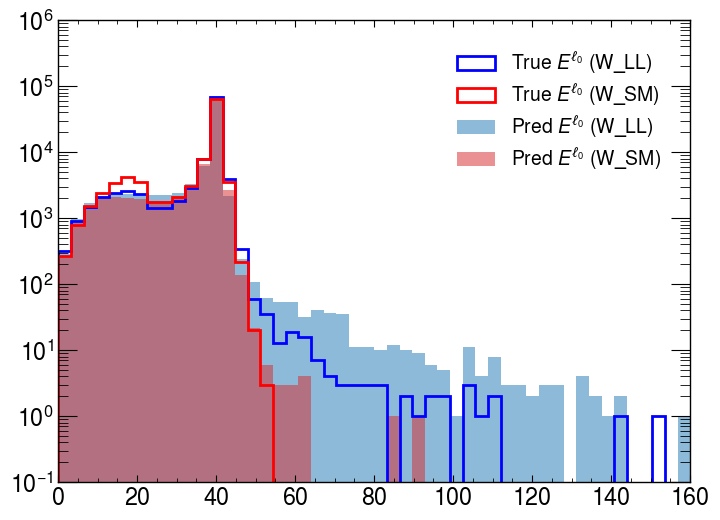

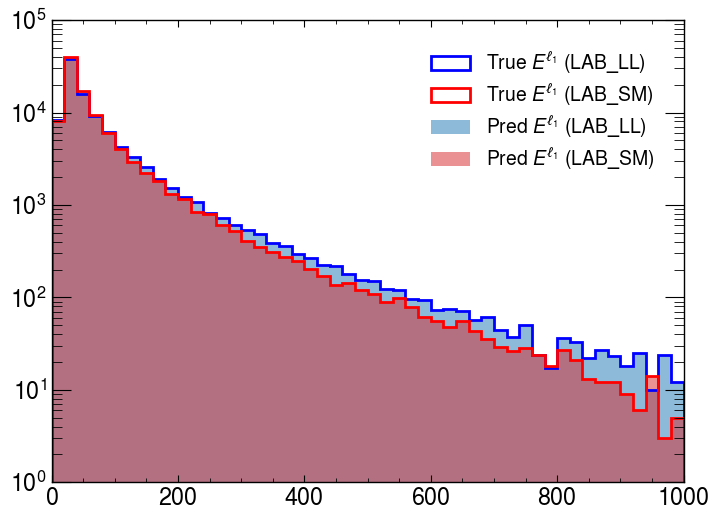

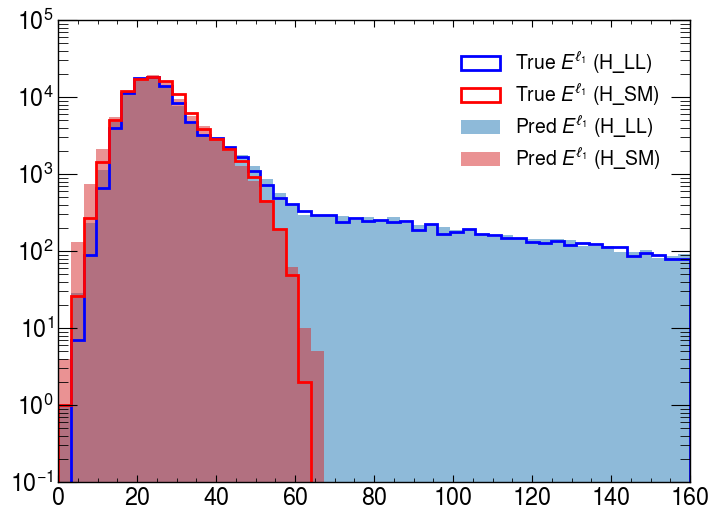

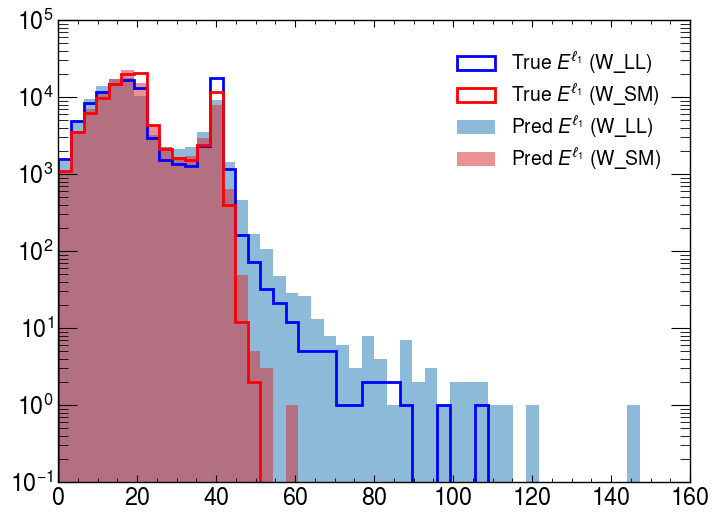

In [69]:
bins_edges = np.linspace(0, 1000, 51)
plt.hist(truth_lab_lp_ll[:,3], bins=bins_edges, label=r"True $E^{\ell_0}$ (LAB_LL)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_lp[:,3], bins=bins_edges, label=r"True $E^{\ell_0}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lab_lp_ll[:,3], bins=bins_edges, label=r"Pred $E^{\ell_0}$ (LAB_LL)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.5)
plt.hist(lab_lp[:,3], bins=bins_edges, label=r"Pred $E^{\ell_0}$ (LAB_SM)", histtype="bar", linewidth=2, color="tab:red", alpha=0.5)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 160, 51)
plt.hist(truth_h_rest_lp_ll[:,3], bins=bins_edges, label=r"True $E^{\ell_0}$ (H_LL)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_lp[:,3], bins=bins_edges, label=r"True $E^{\ell_0}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(h_rest_lp_ll[:,3], bins=bins_edges, label=r"Pred $E^{\ell_0}$ (H_LL)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.5)
plt.hist(h_rest_lp[:,3], bins=bins_edges, label=r"Pred $E^{\ell_0}$ (H_SM)", histtype="bar", linewidth=2, color="tab:red", alpha=0.5)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 160, 51)
plt.hist(truth_w_rest_lp_ll[:,3], bins=bins_edges, label=r"True $E^{\ell_0}$ (W_LL)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_lp[:,3], bins=bins_edges, label=r"True $E^{\ell_0}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(w_rest_lp_ll[:,3], bins=bins_edges, label=r"Pred $E^{\ell_0}$ (W_LL)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.5)
plt.hist(w_rest_lp[:,3], bins=bins_edges, label=r"Pred $E^{\ell_0}$ (W_SM)", histtype="bar", linewidth=2, color="tab:red", alpha=0.5)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 1000, 51)
plt.hist(truth_lab_ln_ll[:,3], bins=bins_edges, label=r"True $E^{\ell_1}$ (LAB_LL)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_lab_ln[:,3], bins=bins_edges, label=r"True $E^{\ell_1}$ (LAB_SM)", histtype="step", linewidth=2, color="red")
plt.hist(lab_ln_ll[:,3], bins=bins_edges, label=r"Pred $E^{\ell_1}$ (LAB_LL)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.5)
plt.hist(lab_ln[:,3], bins=bins_edges, label=r"Pred $E^{\ell_1}$ (LAB_SM)", histtype="bar", linewidth=2, color="tab:red", alpha=0.5)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 160, 51)
plt.hist(truth_h_rest_ln_ll[:,3], bins=bins_edges, label=r"True $E^{\ell_1}$ (H_LL)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_h_rest_ln[:,3], bins=bins_edges, label=r"True $E^{\ell_1}$ (H_SM)", histtype="step", linewidth=2, color="red")
plt.hist(h_rest_ln_ll[:,3], bins=bins_edges, label=r"Pred $E^{\ell_1}$ (H_LL)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.5)
plt.hist(h_rest_ln[:,3], bins=bins_edges, label=r"Pred $E^{\ell_1}$ (H_SM)", histtype="bar", linewidth=2, color="tab:red", alpha=0.5)
plt.semilogy()
plt.legend()
plt.show()

bins_edges = np.linspace(0, 160, 51)
plt.hist(truth_w_rest_ln_ll[:,3], bins=bins_edges, label=r"True $E^{\ell_1}$ (W_LL)", histtype="step", linewidth=2, color="blue")
plt.hist(truth_w_rest_ln[:,3], bins=bins_edges, label=r"True $E^{\ell_1}$ (W_SM)", histtype="step", linewidth=2, color="red")
plt.hist(w_rest_ln_ll[:,3], bins=bins_edges, label=r"Pred $E^{\ell_1}$ (W_LL)", histtype="bar", linewidth=2, color="tab:blue", alpha=0.5)
plt.hist(w_rest_ln[:,3], bins=bins_edges, label=r"Pred $E^{\ell_1}$ (W_SM)", histtype="bar", linewidth=2, color="tab:red", alpha=0.5)
plt.semilogy()
plt.legend()
plt.show()